# Import packages

In [1]:
# -----------------------------------------------------------------------------
# region import packages

# management
import glob
import pickle
import warnings
warnings.filterwarnings('ignore')
import os
import sys  # print(sys.path)
sys.path.append('/work/ollie/qigao001')
sys.path.append('/home/users/qino')
os.chdir('/home/users/qino')

# data analysis
import numpy as np
import xarray as xr
import dask
dask.config.set({"array.slicing.split_large_chunks": True})
# from dask.diagnostics import ProgressBar
# pbar = ProgressBar()
# pbar.register()
from scipy import stats
import xesmf as xe
import pandas as pd
from metpy.interpolate import cross_section
from statsmodels.stats import multitest
import pycircstat as circ
from scipy.stats import circstd
import cmip6_preprocessing.preprocessing as cpp

# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib import cm
import cartopy.crs as ccrs
plt.rcParams['pcolor.shading'] = 'auto'
mpl.rcParams['figure.dpi'] = 600
mpl.rc('font', family='Times New Roman', size=10)
mpl.rcParams['axes.linewidth'] = 0.2
plt.rcParams.update({"mathtext.fontset": "stix"})
import matplotlib.animation as animation
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
import cartopy.feature as cfeature

# self defined
from a_basic_analysis.b_module.mapplot import (
    globe_plot,
    hemisphere_plot,
    quick_var_plot,
    mesh2plot,
    framework_plot1,
    remove_trailing_zero,
    remove_trailing_zero_pos,
    regional_plot,
)

from a_basic_analysis.b_module.basic_calculations import (
    mon_sea_ann,
    regrid,
    find_ilat_ilon,
)

from a_basic_analysis.b_module.namelist import (
    month,
    month_num,
    month_dec,
    month_dec_num,
    seasons,
    seasons_last_num,
    hours,
    months,
    month_days,
    zerok,
    panel_labels,
    seconds_per_d,
)

from a_basic_analysis.b_module.source_properties import (
    source_properties,
    calc_lon_diff,
)

from a_basic_analysis.b_module.statistics import (
    fdr_control_bh,
    check_normality_3d,
    check_equal_variance_3d,
    ttest_fdr_control,
)

from a_basic_analysis.b_module.component_plot import (
    cplot_ice_cores,
    plt_mesh_pars,
)

# endregion
# -----------------------------------------------------------------------------


# Import data

In [2]:
# -----------------------------------------------------------------------------
# region import data

lig_recs = {}

with open('scratch/cmip6/lig/rec/lig_recs_dc.pkl', 'rb') as f:
    lig_recs['DC'] = pickle.load(f)

with open('scratch/cmip6/lig/rec/lig_recs_ec.pkl', 'rb') as f:
    lig_recs['EC'] = pickle.load(f)

with open('scratch/cmip6/lig/rec/lig_recs_jh.pkl', 'rb') as f:
    lig_recs['JH'] = pickle.load(f)

with open('scratch/cmip6/lig/rec/lig_recs_mc.pkl', 'rb') as f:
    lig_recs['MC'] = pickle.load(f)

# endregion
# -----------------------------------------------------------------------------

lig_datasets = pd.read_excel('data_sources/LIG/lig_datasets.xlsx', header=0,)

lig_datasubsets = {}
lig_datasubsets['annual_sst'] = lig_datasets.loc[
    lig_datasets.Type == 'Annual SST']
lig_datasubsets['summer_sst'] = lig_datasets.loc[
    lig_datasets.Type == 'Summer SST']
lig_datasubsets['annual_sat'] = lig_datasets.loc[
    lig_datasets.Type == 'Annual SAT']


# Plot reconstructions and uncertainties

## Antarctic Plot

### Annual SST

Text(0.5, 0, 'LIG annual SST/SAT anomalies [$°C$]')

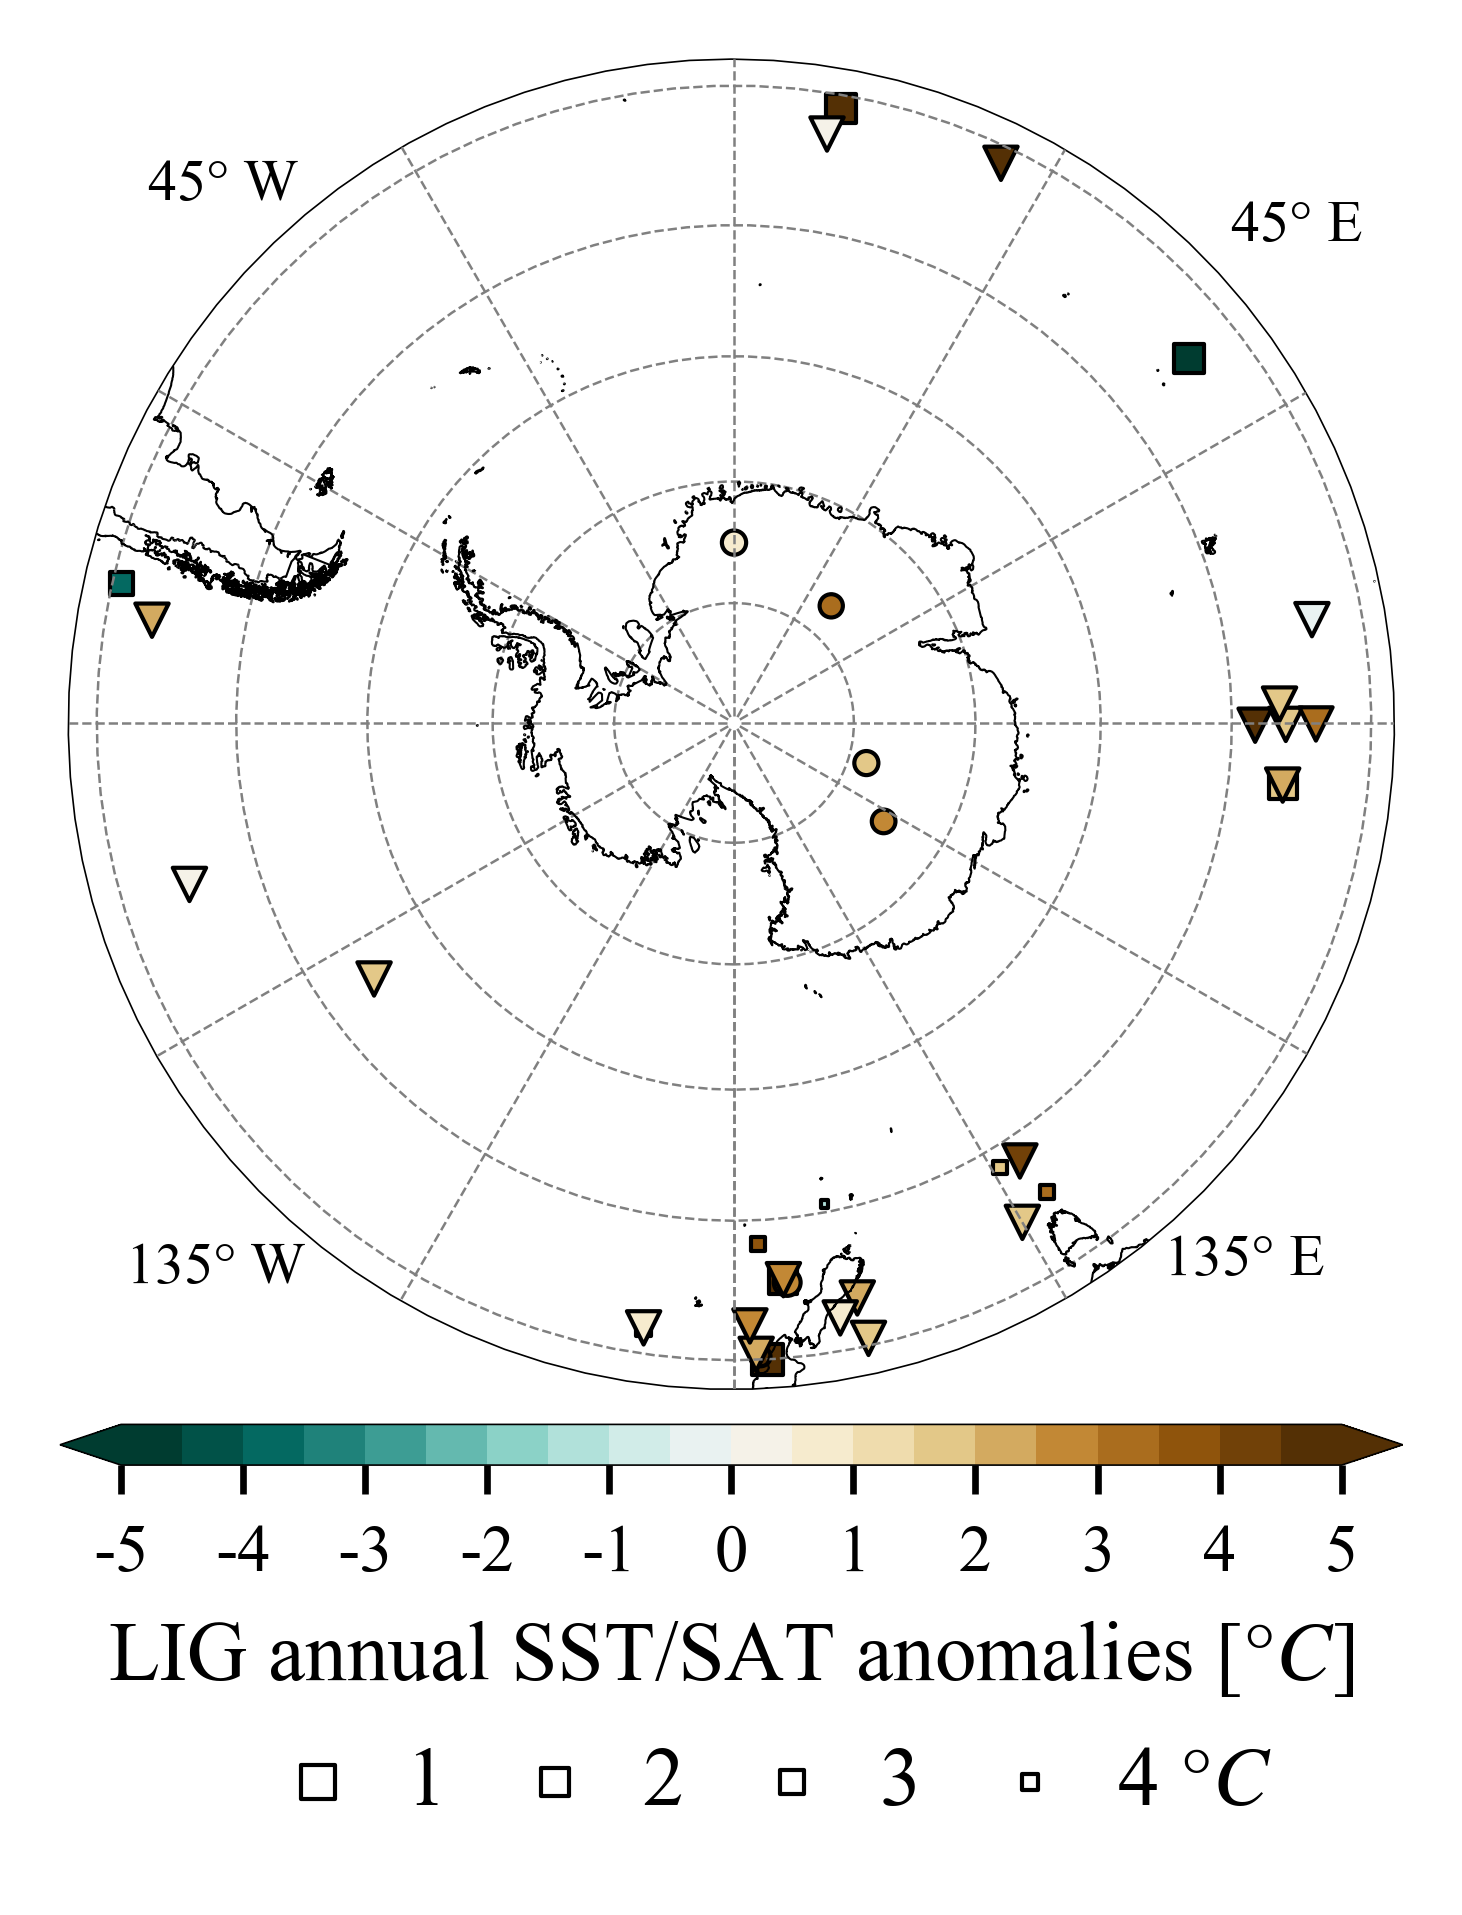

In [3]:
# uncertainties: size
# anomalies: color
# datasets: symbol


cbar_label = 'LIG annual SST/SAT anomalies [$°C$]'

pltlevel, pltticks, pltnorm, pltcmp = plt_mesh_pars(
    cm_min=-5, cm_max=5, cm_interval1=0.5, cm_interval2=1, cmap='BrBG',)

max_size = 20
scale_size = 4

fig, ax = hemisphere_plot(northextent=-38)

# JH
ax.scatter(
    x = lig_recs['JH']['SO_ann'].Longitude,
    y = lig_recs['JH']['SO_ann'].Latitude,
    c = lig_recs['JH']['SO_ann']['127 ka SST anomaly (°C)'],
    s = max_size - scale_size * lig_recs['JH']['SO_ann']['127 ka 2σ (°C)'],
    lw=0.5, marker='s', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# EC SST
ax.scatter(
    x = lig_recs['EC']['SO_ann'].Longitude,
    y = lig_recs['EC']['SO_ann'].Latitude,
    c = lig_recs['EC']['SO_ann']['127 ka Median PIAn [°C]'],
    s = max_size - scale_size * lig_recs['EC']['SO_ann']['127 ka 2s PIAn [°C]'],
    lw=0.5, marker='o', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# EC SAT
ax.scatter(
    x = lig_recs['EC']['AIS_am'].Longitude,
    y = lig_recs['EC']['AIS_am'].Latitude,
    c = lig_recs['EC']['AIS_am']['127 ka Median PIAn [°C]'],
    s = max_size - scale_size * lig_recs['EC']['AIS_am']['127 ka 2s PIAn [°C]'],
    lw=0.5, marker='o', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# DC
ax.scatter(
    x = lig_recs['DC']['annual_128'].Longitude,
    y = lig_recs['DC']['annual_128'].Latitude,
    c = lig_recs['DC']['annual_128']['sst_anom_hadisst_ann'],
    s = max_size - scale_size * 1,
    lw=0.5, marker='v', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)


l1 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 1,
    lw=0.5, edgecolors = 'black',)
l2 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 2,
    lw=0.5, edgecolors = 'black',)
l3 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 3,
    lw=0.5, edgecolors = 'black',)
l4 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 4,
    lw=0.5, edgecolors = 'black',)
plt.legend(
    [l1, l2, l3, l4,], ['1', '2', '3', '4 $°C$'], ncol=4, frameon=False,
    loc = (0.1, -0.35), handletextpad=0.05, columnspacing=0.3,)

cbar = fig.colorbar(
    cm.ScalarMappable(norm=pltnorm, cmap=pltcmp), ax=ax, aspect=30,
    orientation="horizontal", shrink=1, ticks=pltticks, extend='both',
    pad=0.02, fraction=0.22, format=remove_trailing_zero_pos,
    )
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xlabel(cbar_label, linespacing=1.5)


### Summer SST

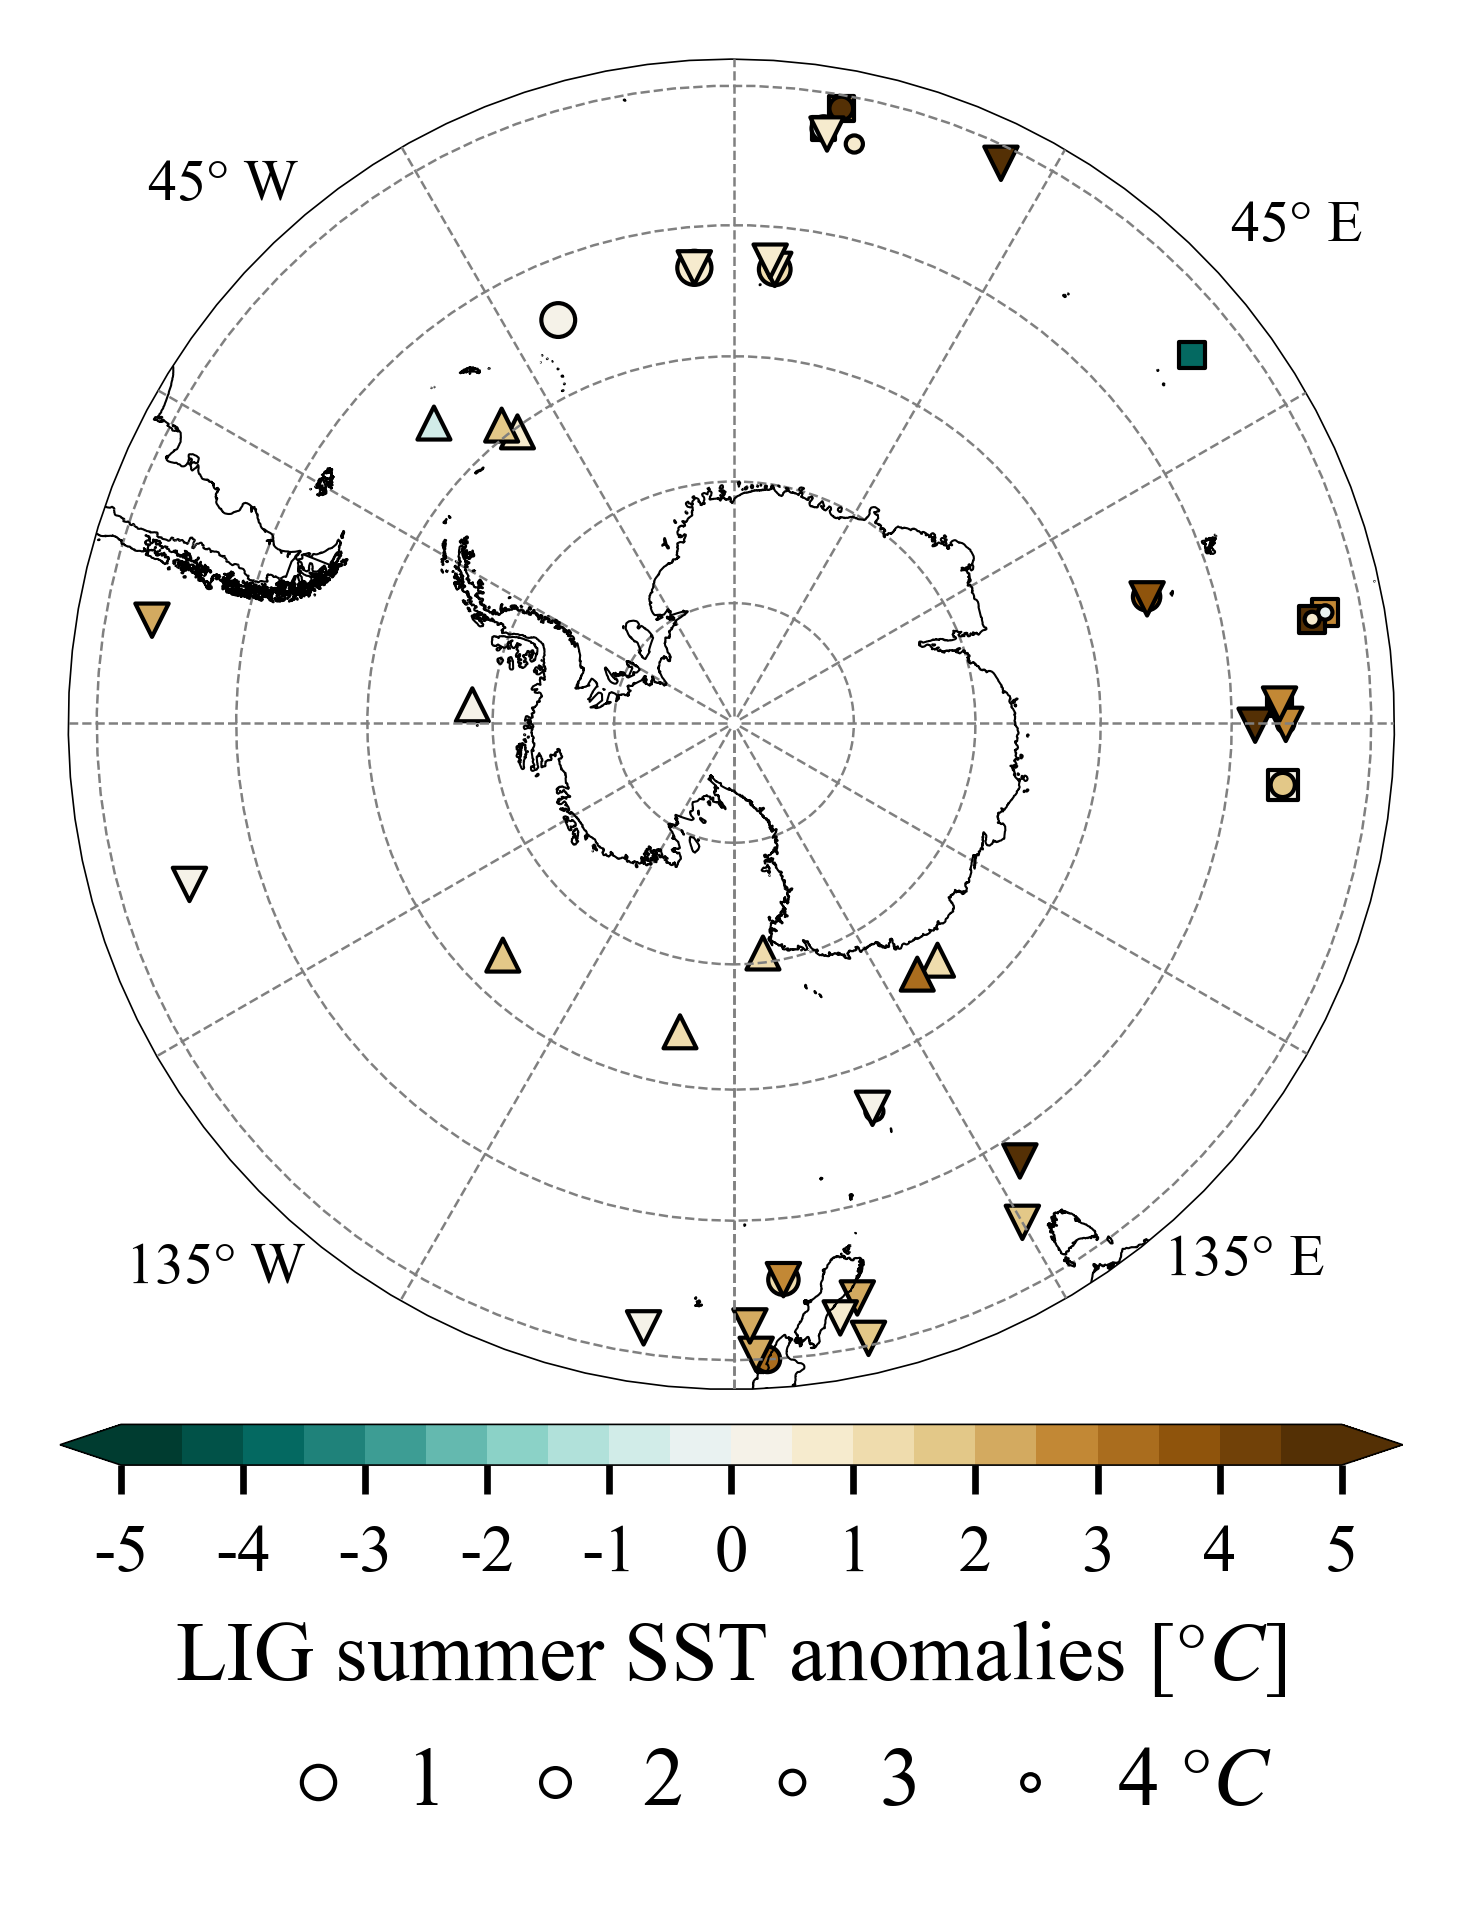

In [4]:
cbar_label = 'LIG summer SST anomalies [$°C$]'

pltlevel, pltticks, pltnorm, pltcmp = plt_mesh_pars(
    cm_min=-5, cm_max=5, cm_interval1=0.5, cm_interval2=1, cmap='BrBG',)

max_size = 20
scale_size = 4

fig, ax = hemisphere_plot(northextent=-38)

# JH
ax.scatter(
    x = lig_recs['JH']['SO_jfm'].Longitude,
    y = lig_recs['JH']['SO_jfm'].Latitude,
    c = lig_recs['JH']['SO_jfm']['127 ka SST anomaly (°C)'],
    s = max_size - scale_size * lig_recs['JH']['SO_jfm']['127 ka 2σ (°C)'],
    lw=0.5, marker='s', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# EC
ax.scatter(
    x = lig_recs['EC']['SO_jfm'].Longitude,
    y = lig_recs['EC']['SO_jfm'].Latitude,
    c = lig_recs['EC']['SO_jfm']['127 ka Median PIAn [°C]'],
    s = max_size - scale_size * lig_recs['EC']['SO_jfm']['127 ka 2s PIAn [°C]'],
    lw=0.5, marker='o', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# MC
ax.scatter(
    x = lig_recs['MC']['interpolated'].Longitude,
    y = lig_recs['MC']['interpolated'].Latitude,
    c = lig_recs['MC']['interpolated']['sst_anom_hadisst_jfm'],
    s = max_size - scale_size * 1.09,
    lw=0.5, marker='^', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# DC
ax.scatter(
    x = lig_recs['DC']['JFM_128'].Longitude,
    y = lig_recs['DC']['JFM_128'].Latitude,
    c = lig_recs['DC']['JFM_128']['sst_anom_hadisst_jfm'],
    s = max_size - scale_size * 1,
    lw=0.5, marker='v', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)


l1 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 1,
    lw=0.5, edgecolors = 'black',)
l2 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 2,
    lw=0.5, edgecolors = 'black',)
l3 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 3,
    lw=0.5, edgecolors = 'black',)
l4 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 4,
    lw=0.5, edgecolors = 'black',)
plt.legend(
    [l1, l2, l3, l4,], ['1', '2', '3', '4 $°C$'], ncol=4, frameon=False,
    loc = (0.1, -0.35), handletextpad=0.05, columnspacing=0.3,)

cbar = fig.colorbar(
    cm.ScalarMappable(norm=pltnorm, cmap=pltcmp), ax=ax, aspect=30,
    orientation="horizontal", shrink=1, ticks=pltticks, extend='both',
    pad=0.02, fraction=0.22, format=remove_trailing_zero_pos,
    )
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xlabel(cbar_label, linespacing=1.5)
cbar.ax.xaxis.set_minor_locator(AutoMinorLocator(1))


### September SIC

Text(0.5, 0, 'LIG Sep SIC anomalies [$\\%$]')

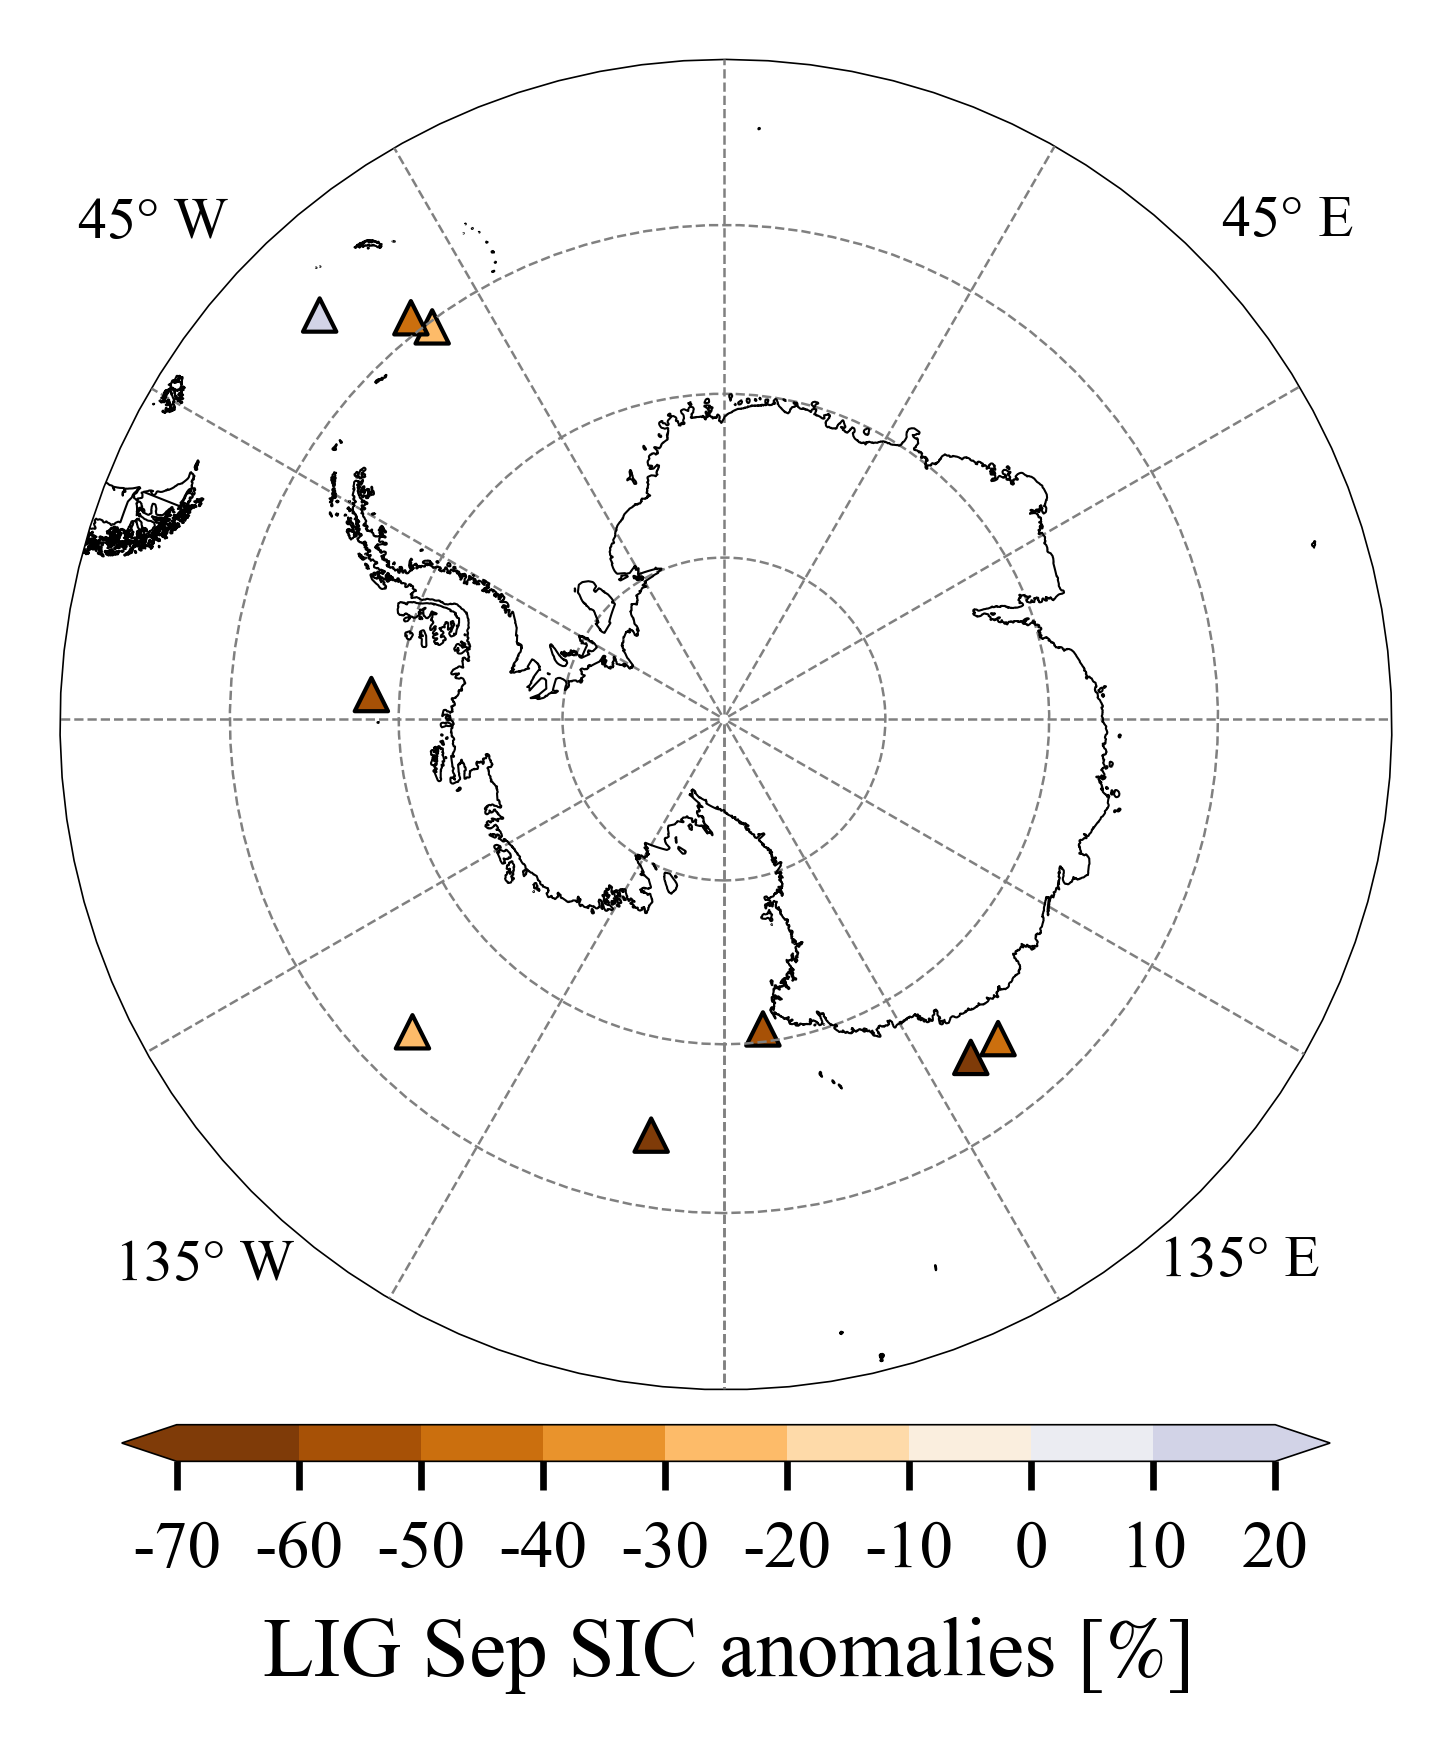

In [5]:
cbar_label = 'LIG Sep SIC anomalies [$\%$]'

pltlevel, pltticks, pltnorm, pltcmp = plt_mesh_pars(
    cm_min=-70, cm_max=20, cm_interval1=10, cm_interval2=10, cmap='PuOr',
    reversed=False, asymmetric=True,)

fig, ax = hemisphere_plot(northextent=-50)

ax.scatter(
    x = lig_recs['MC']['interpolated'].Longitude,
    y = lig_recs['MC']['interpolated'].Latitude,
    c = lig_recs['MC']['interpolated']['sic_anom_hadisst_sep'],
    s=16, lw=0.5, marker='^', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

cbar = fig.colorbar(
    cm.ScalarMappable(norm=pltnorm, cmap=pltcmp), ax=ax, aspect=30,
    orientation="horizontal", shrink=0.9, ticks=pltticks, extend='both',
    pad=0.02, fraction=0.22, format=remove_trailing_zero_pos,
    )
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xlabel(cbar_label, linespacing=1.5)


## Atlantic sector plot

### Annual SST

Text(0.5, 0, 'LIG annual SST/SAT anomalies [$°C$]')

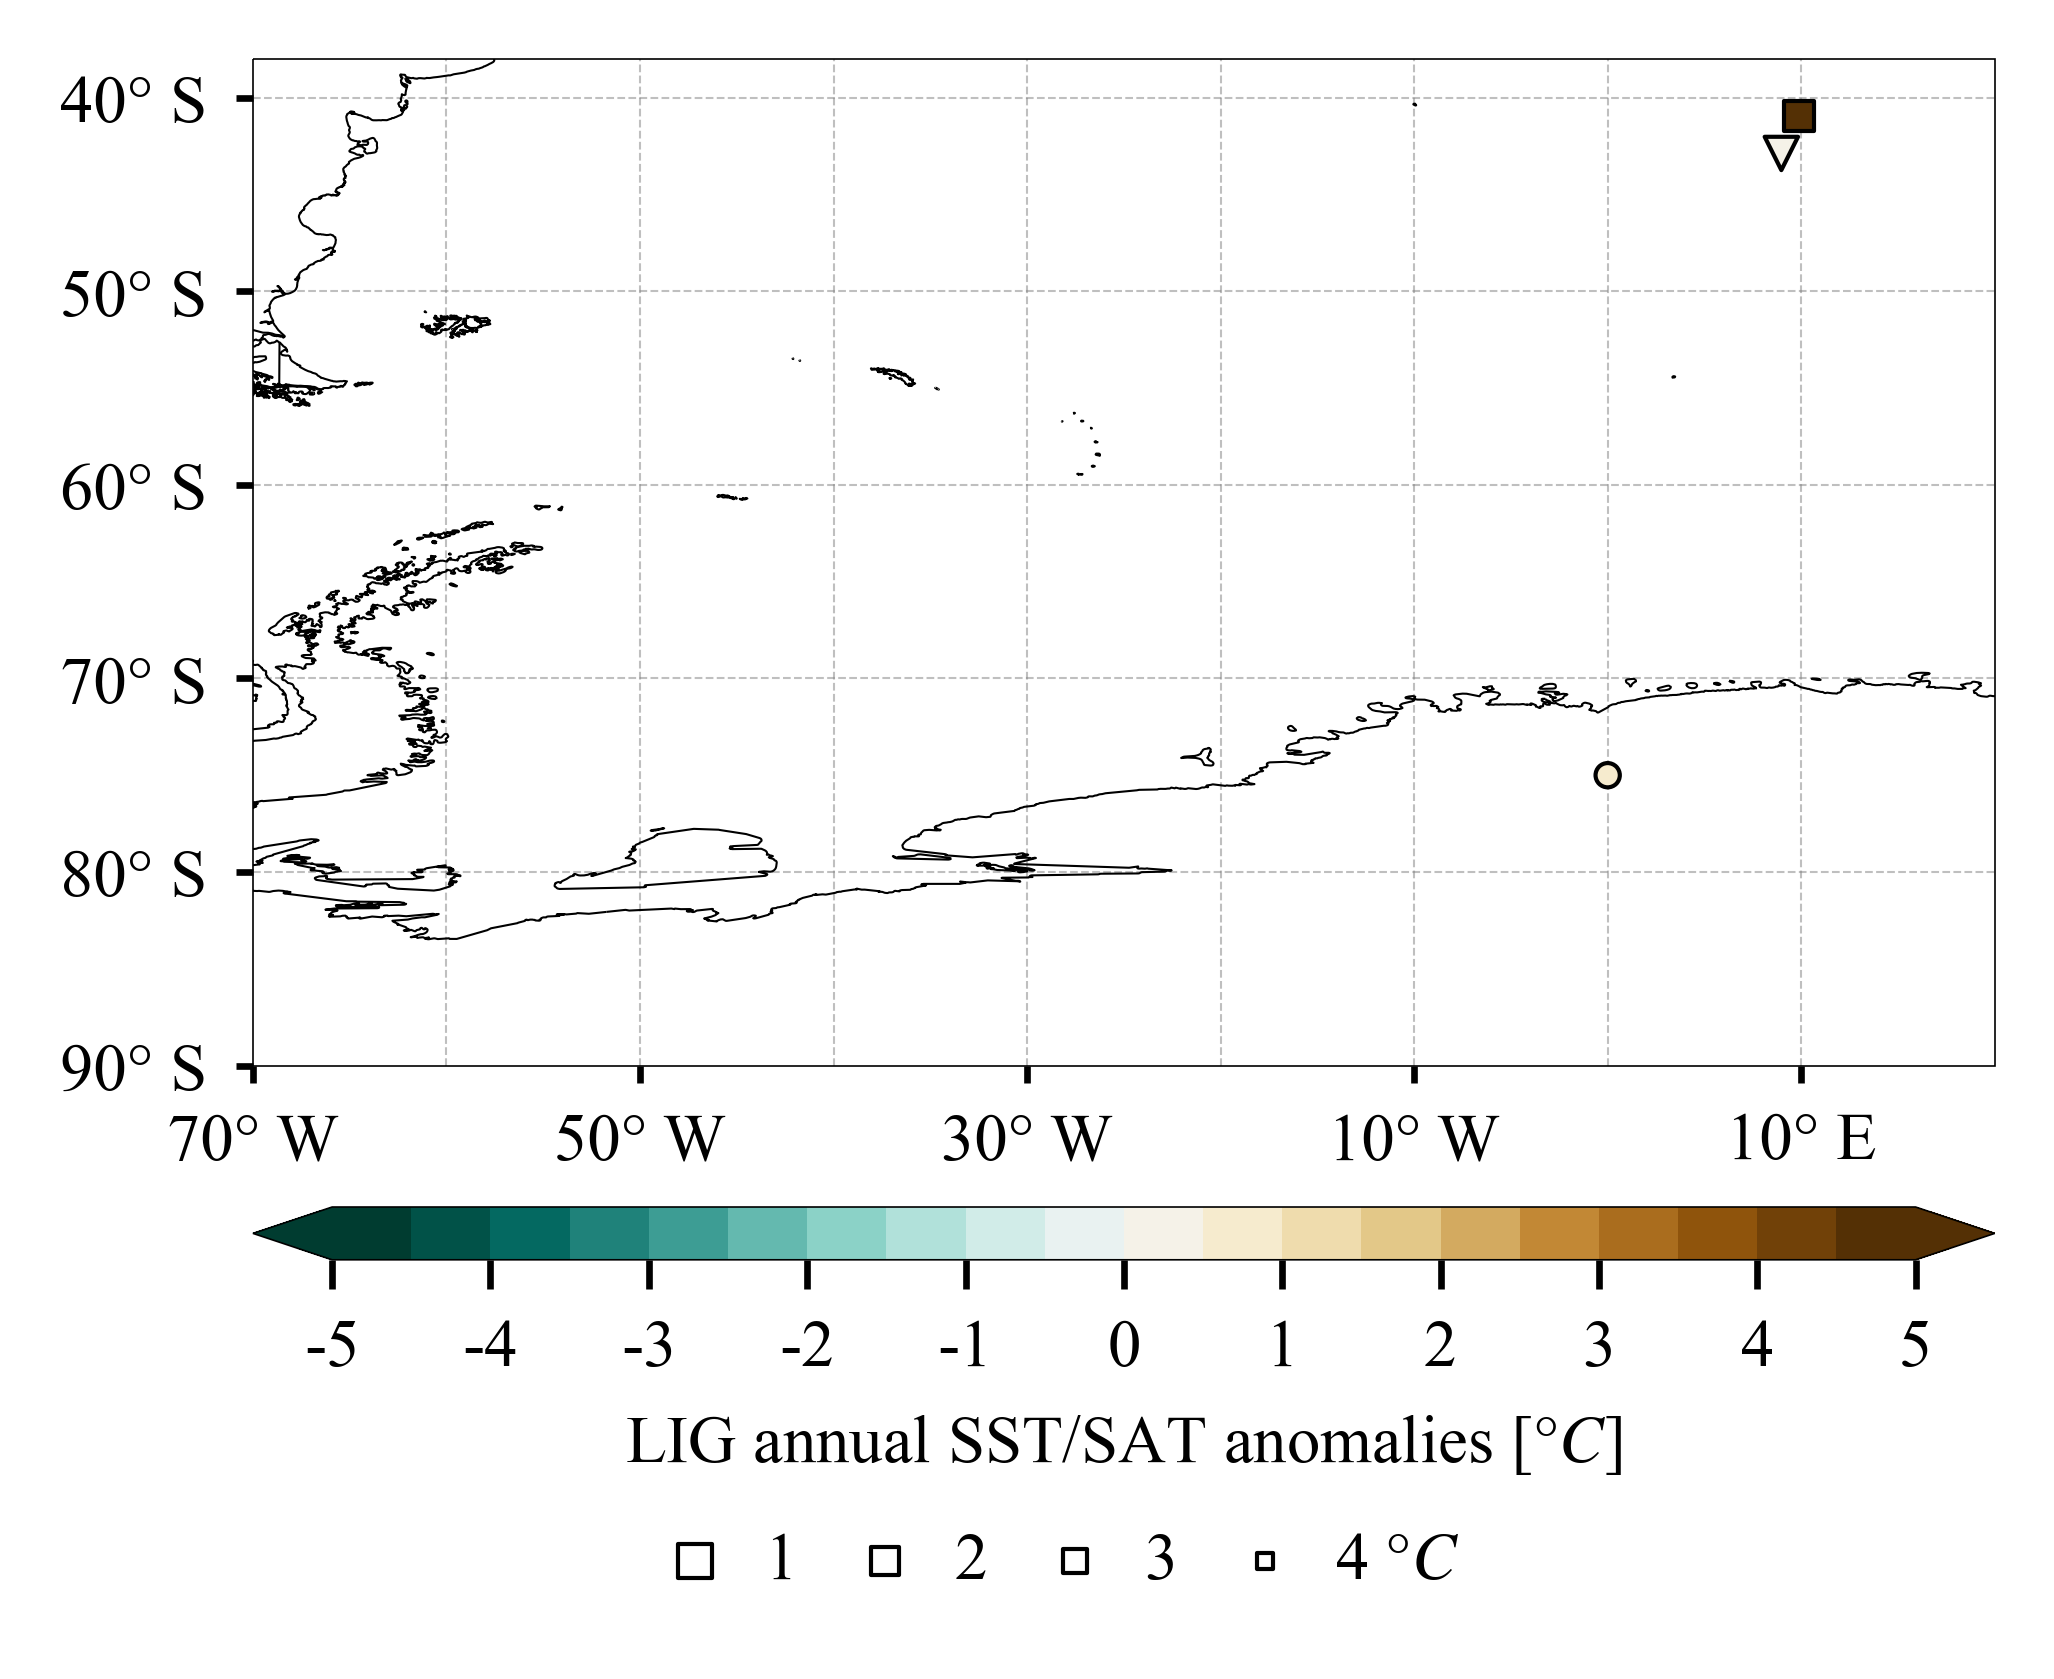

In [6]:
extent=[-70, 20, -90, -38]
fig, ax = regional_plot(extent=extent, figsize = np.array([8.8, 6.6]) / 2.54)

cbar_label = 'LIG annual SST/SAT anomalies [$°C$]'

pltlevel, pltticks, pltnorm, pltcmp = plt_mesh_pars(
    cm_min=-5, cm_max=5, cm_interval1=0.5, cm_interval2=1, cmap='BrBG',)

max_size = 20
scale_size = 4

# JH
ax.scatter(
    x = lig_recs['JH']['SO_ann'].Longitude,
    y = lig_recs['JH']['SO_ann'].Latitude,
    c = lig_recs['JH']['SO_ann']['127 ka SST anomaly (°C)'],
    s = max_size - scale_size * lig_recs['JH']['SO_ann']['127 ka 2σ (°C)'],
    lw=0.5, marker='s', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# EC SST
ax.scatter(
    x = lig_recs['EC']['SO_ann'].Longitude,
    y = lig_recs['EC']['SO_ann'].Latitude,
    c = lig_recs['EC']['SO_ann']['127 ka Median PIAn [°C]'],
    s = max_size - scale_size * lig_recs['EC']['SO_ann']['127 ka 2s PIAn [°C]'],
    lw=0.5, marker='o', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# EC SAT
ax.scatter(
    x = lig_recs['EC']['AIS_am'].Longitude,
    y = lig_recs['EC']['AIS_am'].Latitude,
    c = lig_recs['EC']['AIS_am']['127 ka Median PIAn [°C]'],
    s = max_size - scale_size * lig_recs['EC']['AIS_am']['127 ka 2s PIAn [°C]'],
    lw=0.5, marker='o', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# DC
plt_scatter = ax.scatter(
    x = lig_recs['DC']['annual_128'].Longitude,
    y = lig_recs['DC']['annual_128'].Latitude,
    c = lig_recs['DC']['annual_128']['sst_anom_hadisst_ann'],
    s = max_size - scale_size * 1,
    lw=0.5, marker='v', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)


l1 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 1,
    lw=0.5, edgecolors = 'black',)
l2 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 2,
    lw=0.5, edgecolors = 'black',)
l3 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 3,
    lw=0.5, edgecolors = 'black',)
l4 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 4,
    lw=0.5, edgecolors = 'black',)
plt.legend(
    [l1, l2, l3, l4,], ['1', '2', '3', '4 $°C$'], ncol=4, frameon=False,
    loc = (0.2, -0.55), handletextpad=0.05, columnspacing=0.3,)

cbar = fig.colorbar(
    plt_scatter, ax=ax, aspect=30,
    orientation="horizontal", shrink=1, ticks=pltticks, extend='both',
    pad=0.1, fraction=0.14, format=remove_trailing_zero_pos,
    )
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xlabel(cbar_label, linespacing=1.5)


### Summer SST

Text(0.5, 0, 'LIG summer SST anomalies [$°C$]')

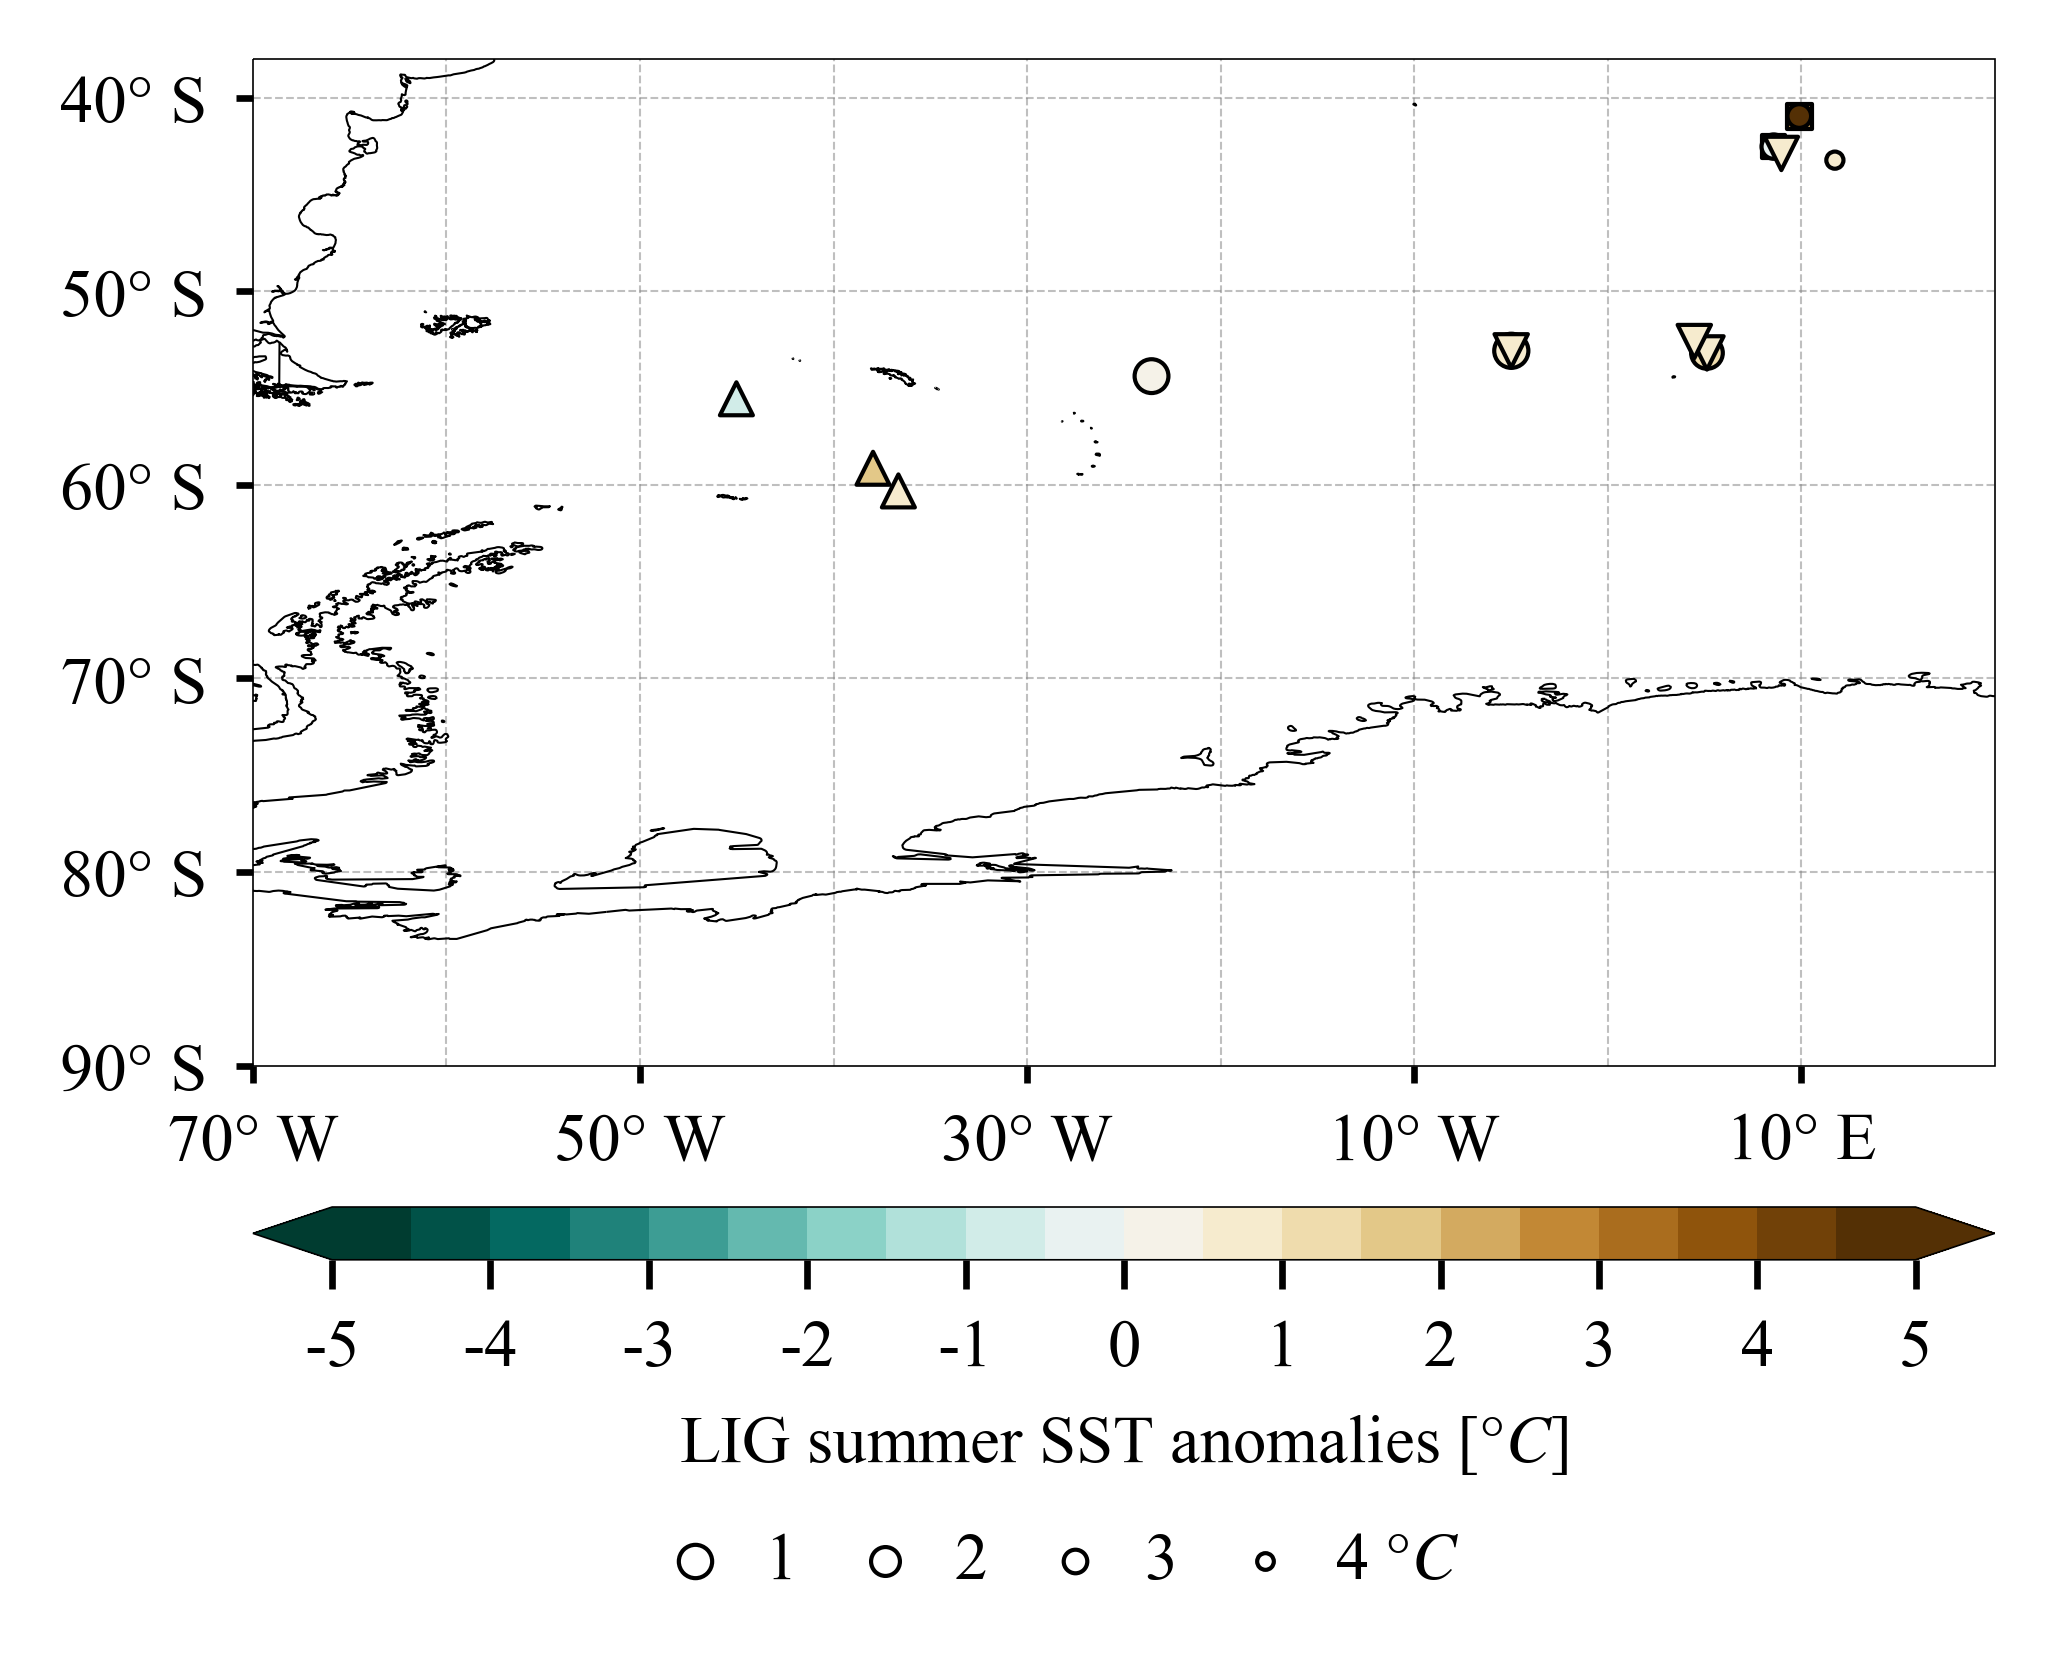

In [7]:

extent=[-70, 20, -90, -38]
fig, ax = regional_plot(extent=extent, figsize = np.array([8.8, 6.6]) / 2.54)

cbar_label = 'LIG summer SST anomalies [$°C$]'

pltlevel, pltticks, pltnorm, pltcmp = plt_mesh_pars(
    cm_min=-5, cm_max=5, cm_interval1=0.5, cm_interval2=1, cmap='BrBG',)

max_size = 20
scale_size = 4

# JH
ax.scatter(
    x = lig_recs['JH']['SO_jfm'].Longitude,
    y = lig_recs['JH']['SO_jfm'].Latitude,
    c = lig_recs['JH']['SO_jfm']['127 ka SST anomaly (°C)'],
    s = max_size - scale_size * lig_recs['JH']['SO_jfm']['127 ka 2σ (°C)'],
    lw=0.5, marker='s', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# EC
ax.scatter(
    x = lig_recs['EC']['SO_jfm'].Longitude,
    y = lig_recs['EC']['SO_jfm'].Latitude,
    c = lig_recs['EC']['SO_jfm']['127 ka Median PIAn [°C]'],
    s = max_size - scale_size * lig_recs['EC']['SO_jfm']['127 ka 2s PIAn [°C]'],
    lw=0.5, marker='o', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# MC
ax.scatter(
    x = lig_recs['MC']['interpolated'].Longitude,
    y = lig_recs['MC']['interpolated'].Latitude,
    c = lig_recs['MC']['interpolated']['sst_anom_hadisst_jfm'],
    s = max_size - scale_size * 1.09,
    lw=0.5, marker='^', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# DC
plt_scatter = ax.scatter(
    x = lig_recs['DC']['JFM_128'].Longitude,
    y = lig_recs['DC']['JFM_128'].Latitude,
    c = lig_recs['DC']['JFM_128']['sst_anom_hadisst_jfm'],
    s = max_size - scale_size * 1,
    lw=0.5, marker='v', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)


l1 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 1,
    lw=0.5, edgecolors = 'black',)
l2 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 2,
    lw=0.5, edgecolors = 'black',)
l3 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 3,
    lw=0.5, edgecolors = 'black',)
l4 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 4,
    lw=0.5, edgecolors = 'black',)
plt.legend(
    [l1, l2, l3, l4,], ['1', '2', '3', '4 $°C$'], ncol=4, frameon=False,
    loc = (0.2, -0.55), handletextpad=0.05, columnspacing=0.3,)

cbar = fig.colorbar(
    plt_scatter, ax=ax, aspect=30,
    orientation="horizontal", shrink=1, ticks=pltticks, extend='both',
    pad=0.1, fraction=0.14, format=remove_trailing_zero_pos,
    )
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xlabel(cbar_label, linespacing=1.5)


## Indian sector plot

### Annual SST

Text(0.5, 0, 'LIG annual SST/SAT anomalies [$°C$]')

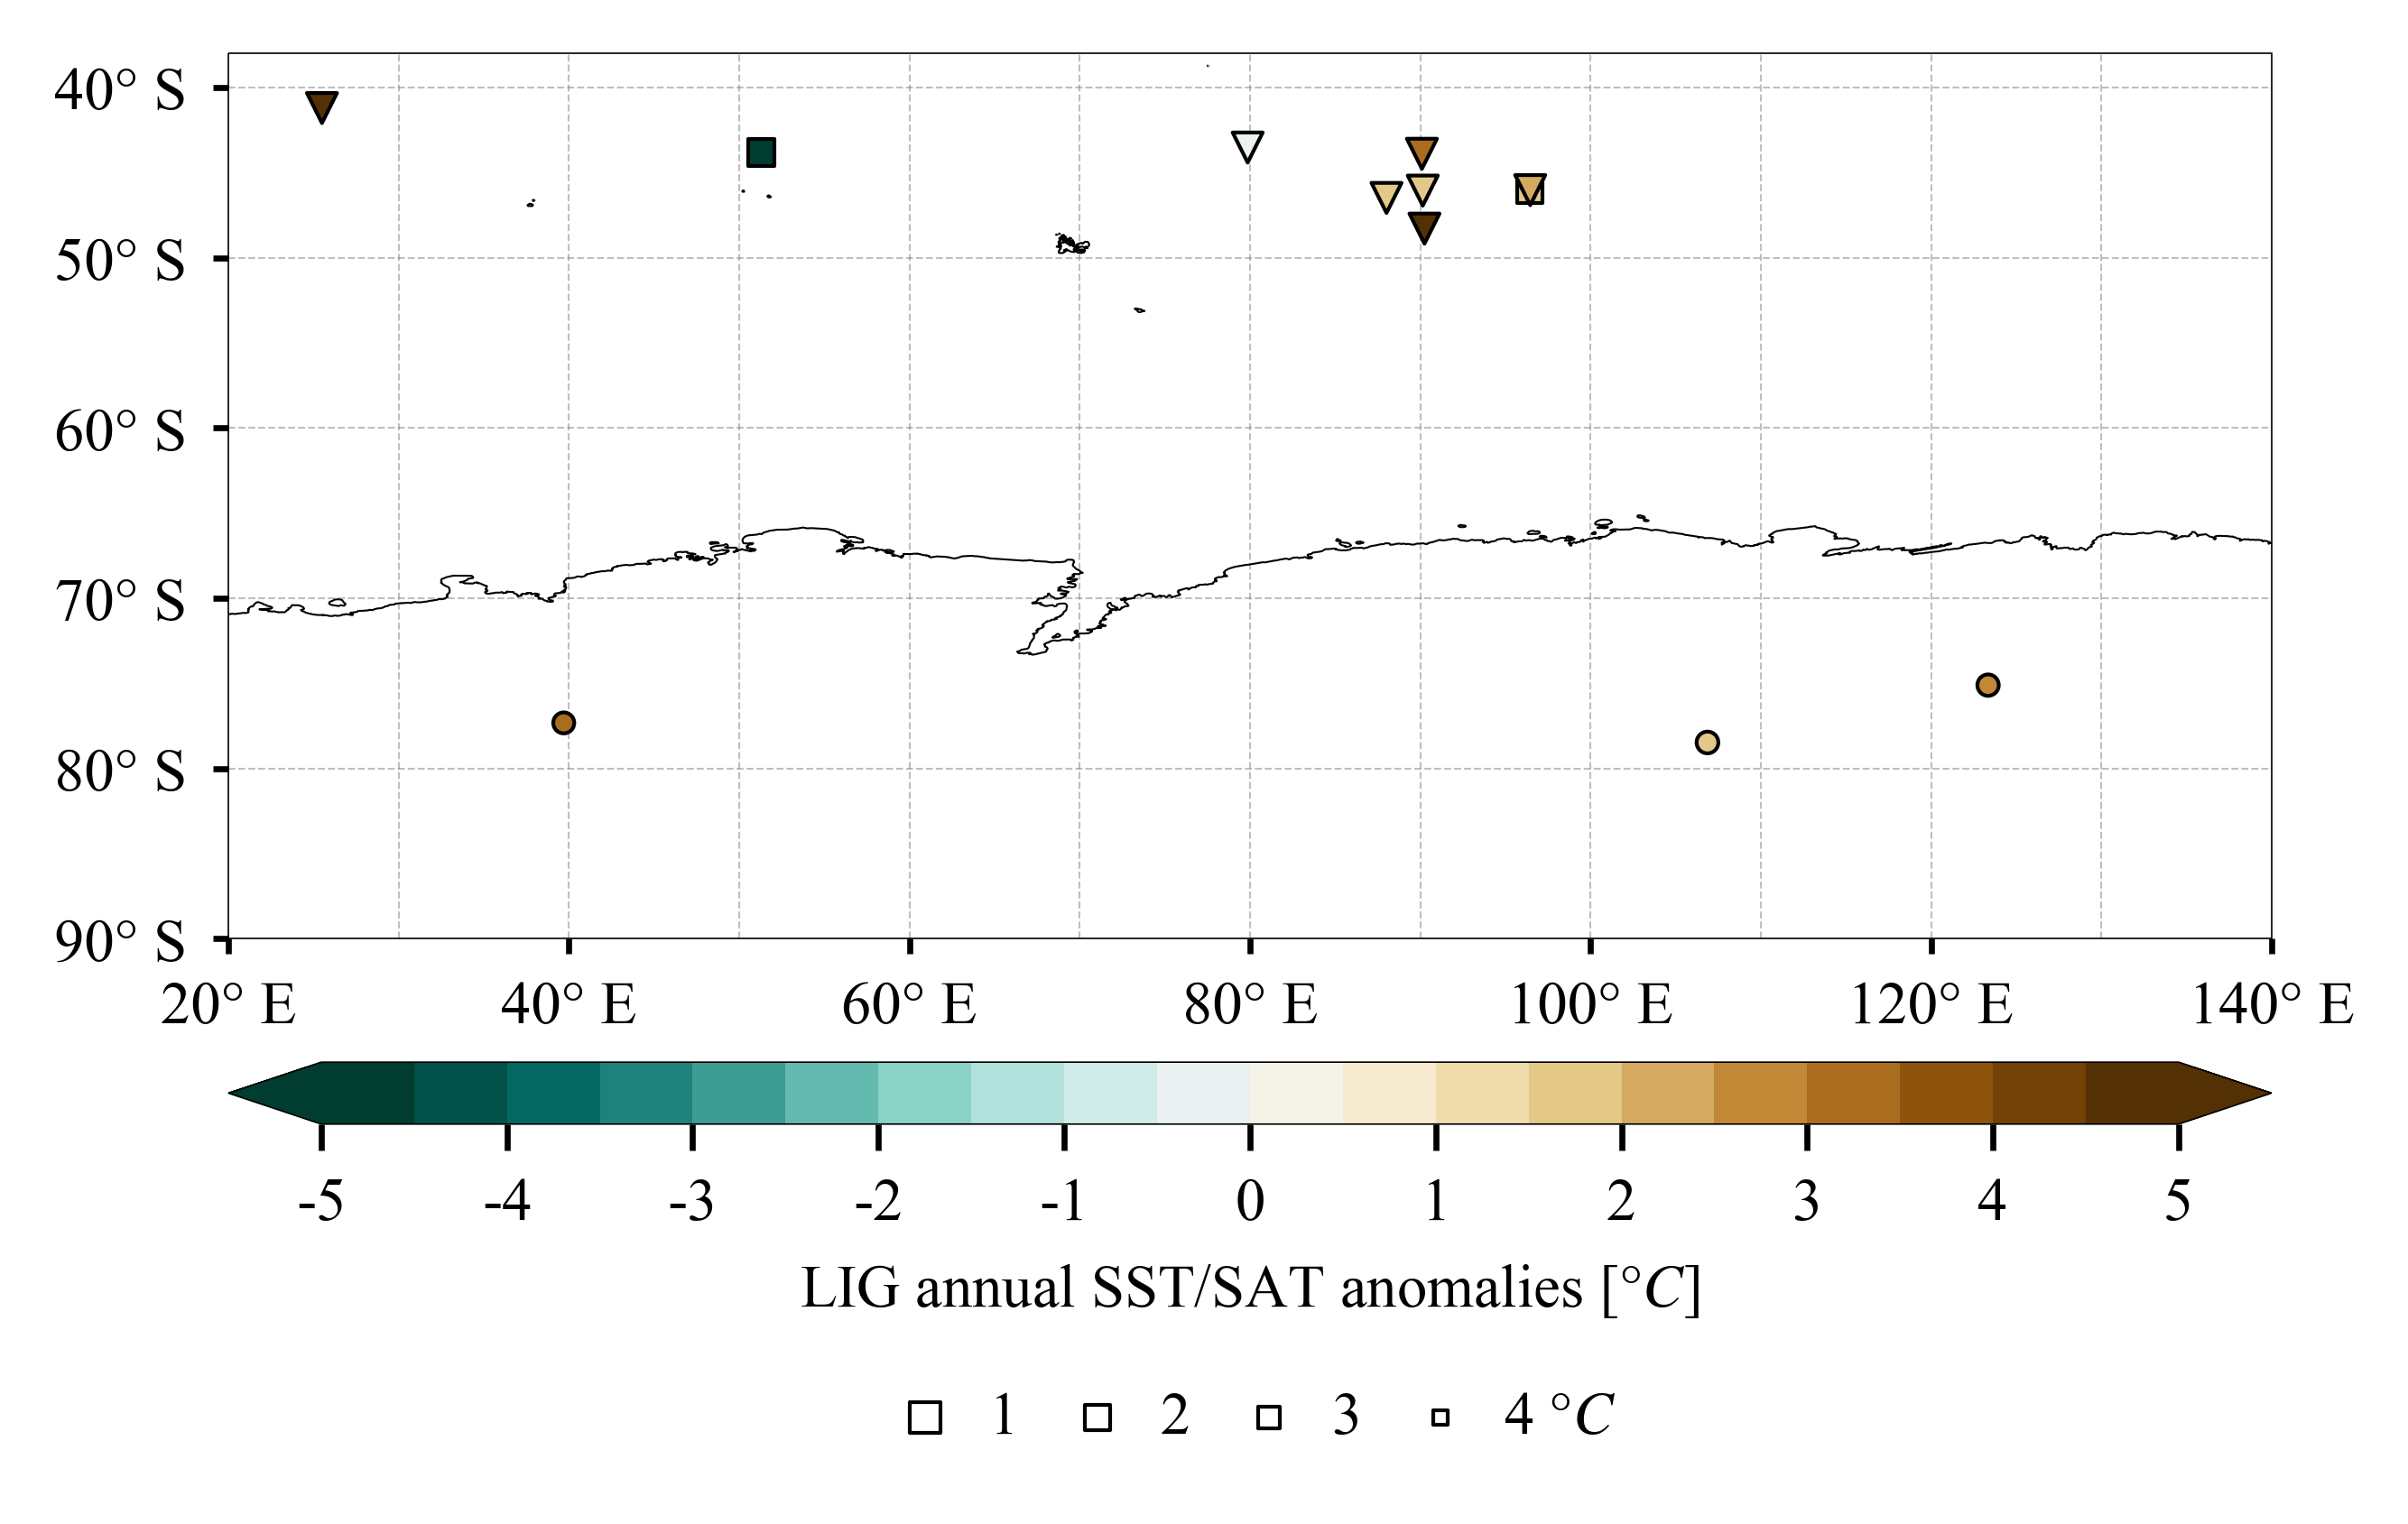

In [8]:
extent=[20, 140, -90, -38]
fig, ax = regional_plot(extent=extent, figsize = np.array([11.4, 6.4]) / 2.54)

cbar_label = 'LIG annual SST/SAT anomalies [$°C$]'

pltlevel, pltticks, pltnorm, pltcmp = plt_mesh_pars(
    cm_min=-5, cm_max=5, cm_interval1=0.5, cm_interval2=1, cmap='BrBG',)

max_size = 20
scale_size = 4

# JH
ax.scatter(
    x = lig_recs['JH']['SO_ann'].Longitude,
    y = lig_recs['JH']['SO_ann'].Latitude,
    c = lig_recs['JH']['SO_ann']['127 ka SST anomaly (°C)'],
    s = max_size - scale_size * lig_recs['JH']['SO_ann']['127 ka 2σ (°C)'],
    lw=0.5, marker='s', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# EC SST
ax.scatter(
    x = lig_recs['EC']['SO_ann'].Longitude,
    y = lig_recs['EC']['SO_ann'].Latitude,
    c = lig_recs['EC']['SO_ann']['127 ka Median PIAn [°C]'],
    s = max_size - scale_size * lig_recs['EC']['SO_ann']['127 ka 2s PIAn [°C]'],
    lw=0.5, marker='o', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# EC SAT
ax.scatter(
    x = lig_recs['EC']['AIS_am'].Longitude,
    y = lig_recs['EC']['AIS_am'].Latitude,
    c = lig_recs['EC']['AIS_am']['127 ka Median PIAn [°C]'],
    s = max_size - scale_size * lig_recs['EC']['AIS_am']['127 ka 2s PIAn [°C]'],
    lw=0.5, marker='o', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# DC
plt_scatter = ax.scatter(
    x = lig_recs['DC']['annual_128'].Longitude,
    y = lig_recs['DC']['annual_128'].Latitude,
    c = lig_recs['DC']['annual_128']['sst_anom_hadisst_ann'],
    s = max_size - scale_size * 1,
    lw=0.5, marker='v', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)


l1 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 1,
    lw=0.5, edgecolors = 'black',)
l2 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 2,
    lw=0.5, edgecolors = 'black',)
l3 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 3,
    lw=0.5, edgecolors = 'black',)
l4 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 4,
    lw=0.5, edgecolors = 'black',)
plt.legend(
    [l1, l2, l3, l4,], ['1', '2', '3', '4 $°C$'], ncol=4, frameon=False,
    loc = (0.3, -0.6), handletextpad=0.05, columnspacing=0.3,)

cbar = fig.colorbar(
    plt_scatter, ax=ax, aspect=30,
    orientation="horizontal", shrink=1, ticks=pltticks, extend='both',
    pad=0.1, fraction=0.14, format=remove_trailing_zero_pos,
    )
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xlabel(cbar_label, linespacing=1.5)


### Summer SST

Text(0.5, 0, 'LIG summer SST anomalies [$°C$]')

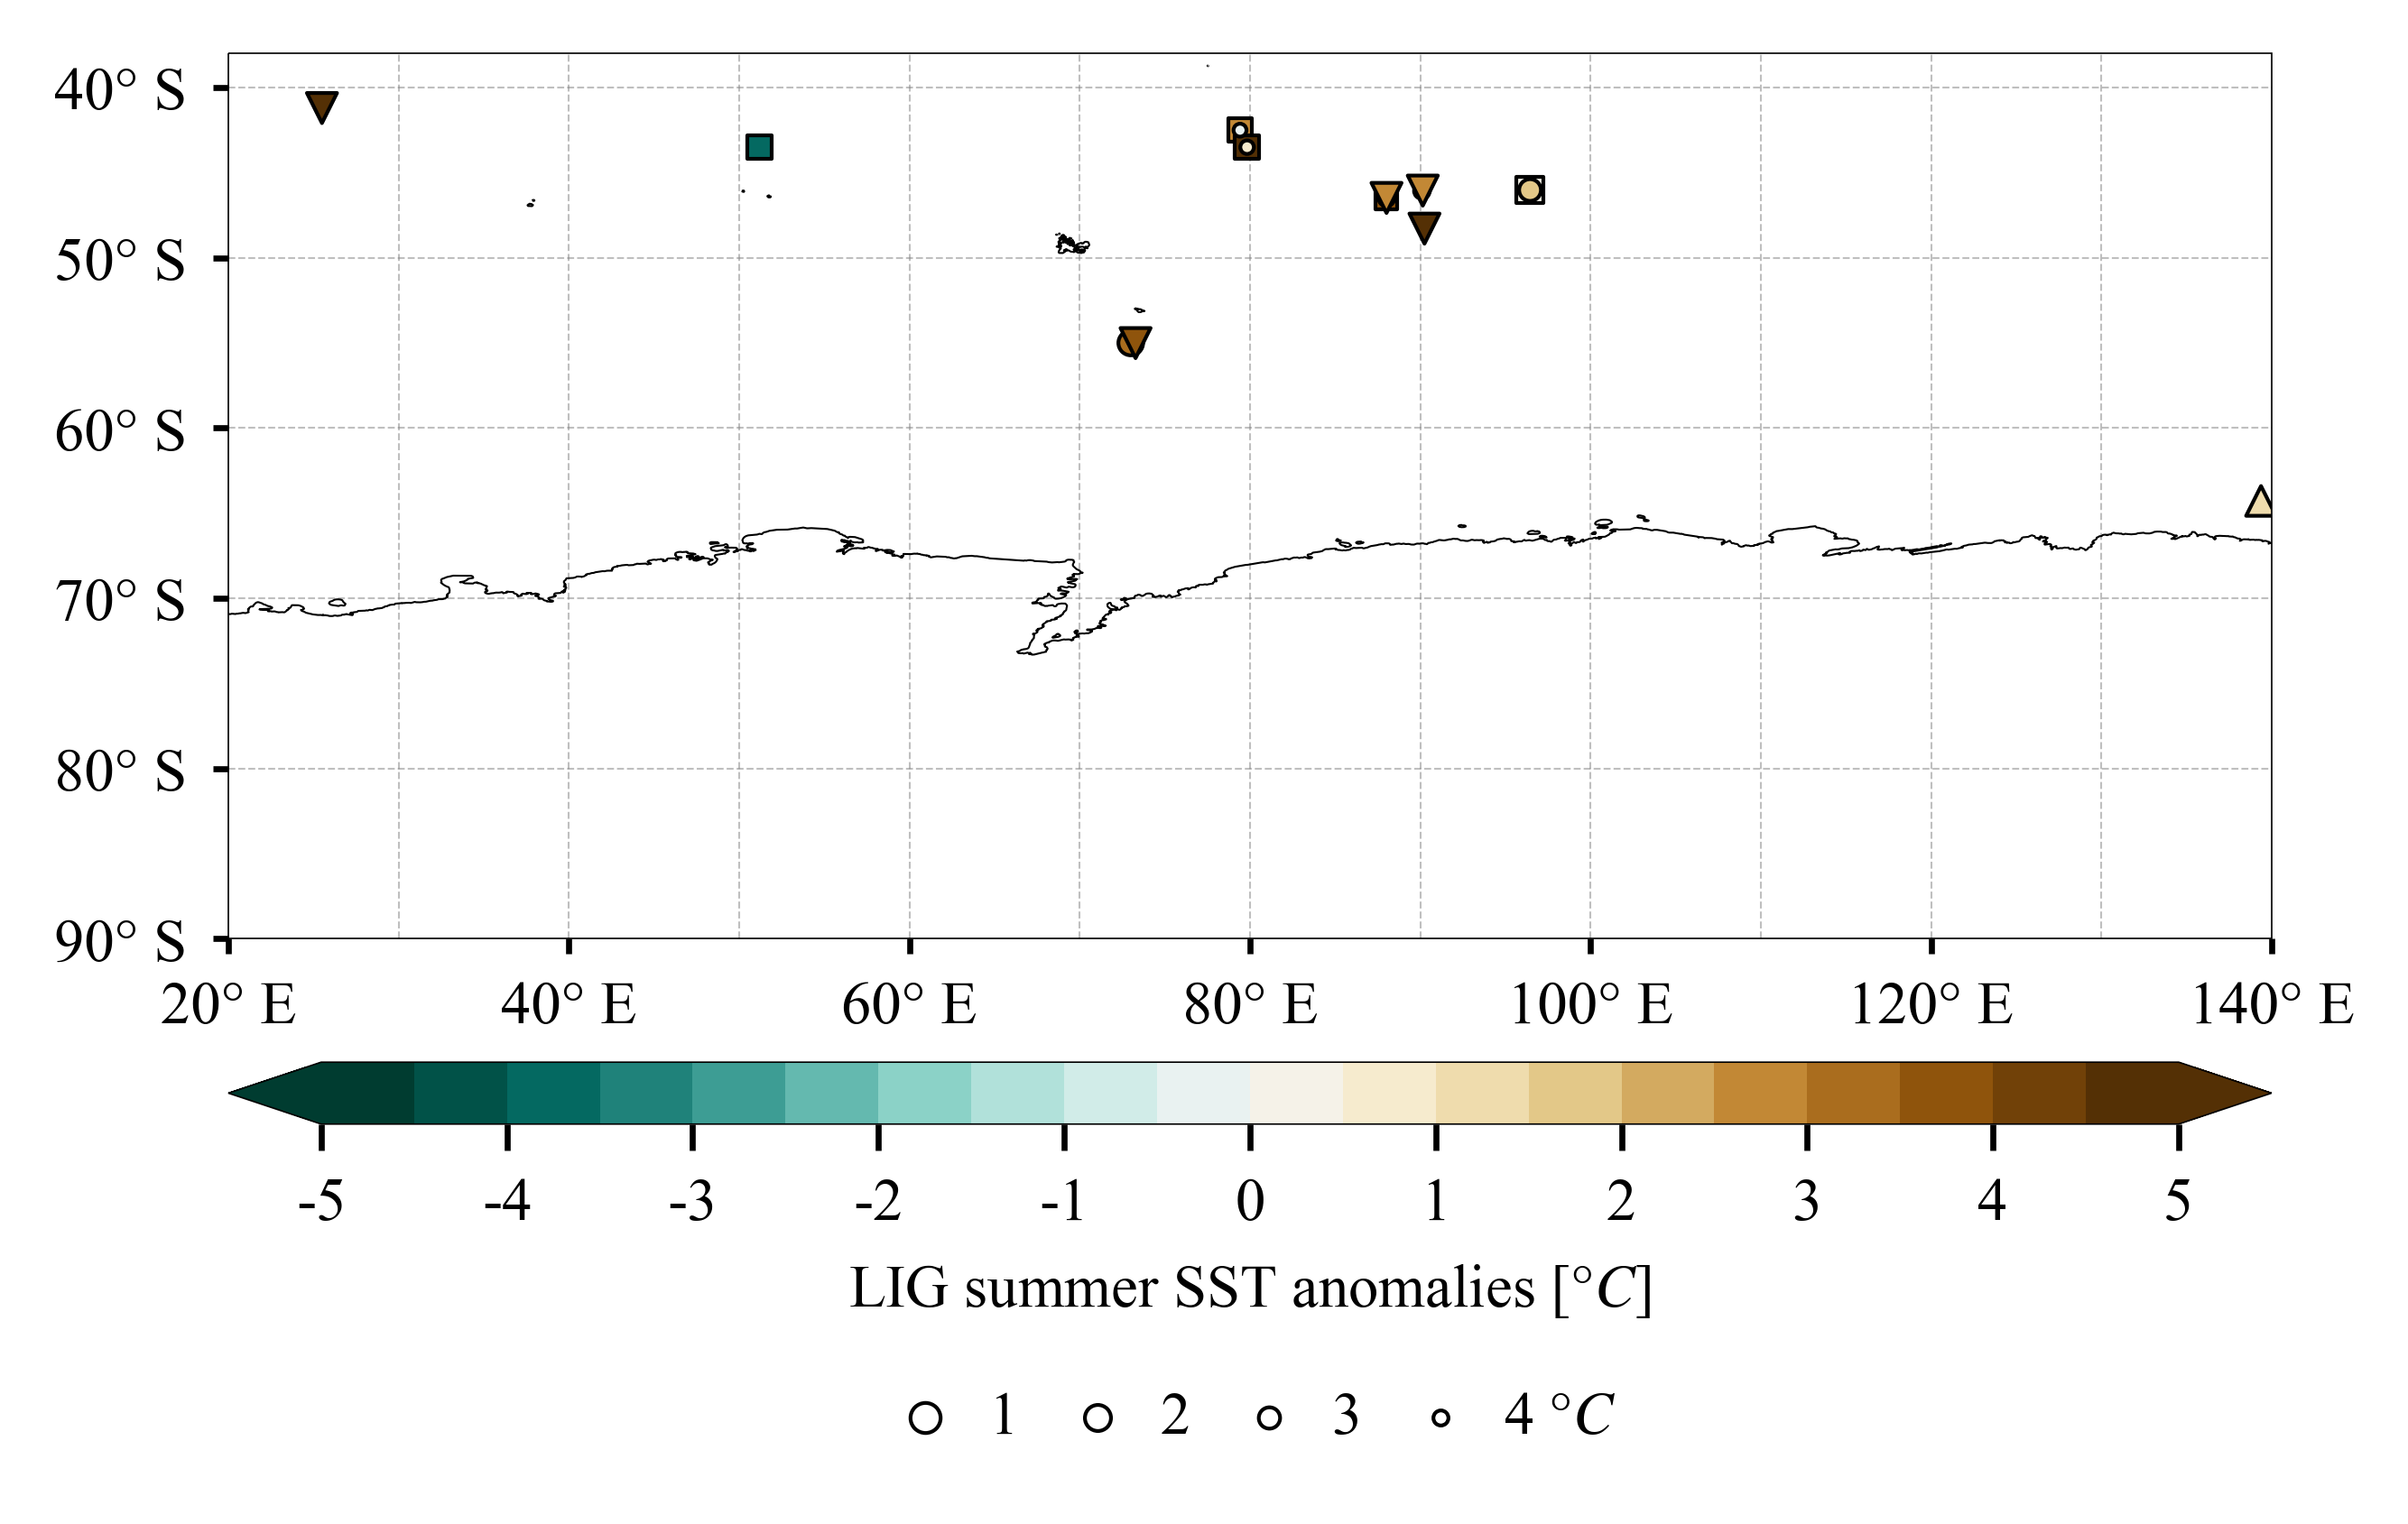

In [12]:

extent=[20, 140, -90, -38]
fig, ax = regional_plot(extent=extent, figsize = np.array([11.4, 6.4]) / 2.54)

cbar_label = 'LIG summer SST anomalies [$°C$]'

pltlevel, pltticks, pltnorm, pltcmp = plt_mesh_pars(
    cm_min=-5, cm_max=5, cm_interval1=0.5, cm_interval2=1, cmap='BrBG',)

max_size = 20
scale_size = 4

# JH
ax.scatter(
    x = lig_recs['JH']['SO_jfm'].Longitude,
    y = lig_recs['JH']['SO_jfm'].Latitude,
    c = lig_recs['JH']['SO_jfm']['127 ka SST anomaly (°C)'],
    s = max_size - scale_size * lig_recs['JH']['SO_jfm']['127 ka 2σ (°C)'],
    lw=0.5, marker='s', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# EC
ax.scatter(
    x = lig_recs['EC']['SO_jfm'].Longitude,
    y = lig_recs['EC']['SO_jfm'].Latitude,
    c = lig_recs['EC']['SO_jfm']['127 ka Median PIAn [°C]'],
    s = max_size - scale_size * lig_recs['EC']['SO_jfm']['127 ka 2s PIAn [°C]'],
    lw=0.5, marker='o', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# MC
ax.scatter(
    x = lig_recs['MC']['interpolated'].Longitude,
    y = lig_recs['MC']['interpolated'].Latitude,
    c = lig_recs['MC']['interpolated']['sst_anom_hadisst_jfm'],
    s = max_size - scale_size * 1.09,
    lw=0.5, marker='^', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# DC
plt_scatter = ax.scatter(
    x = lig_recs['DC']['JFM_128'].Longitude,
    y = lig_recs['DC']['JFM_128'].Latitude,
    c = lig_recs['DC']['JFM_128']['sst_anom_hadisst_jfm'],
    s = max_size - scale_size * 1,
    lw=0.5, marker='v', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)


l1 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 1,
    lw=0.5, edgecolors = 'black',)
l2 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 2,
    lw=0.5, edgecolors = 'black',)
l3 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 3,
    lw=0.5, edgecolors = 'black',)
l4 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 4,
    lw=0.5, edgecolors = 'black',)
plt.legend(
    [l1, l2, l3, l4,], ['1', '2', '3', '4 $°C$'], ncol=4, frameon=False,
    loc = (0.3, -0.6), handletextpad=0.05, columnspacing=0.3,)

cbar = fig.colorbar(
    plt_scatter, ax=ax, aspect=30,
    orientation="horizontal", shrink=1, ticks=pltticks, extend='both',
    pad=0.1, fraction=0.14, format=remove_trailing_zero_pos,
    )
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xlabel(cbar_label, linespacing=1.5)


## Pacific sector plot

### Annual SST

Text(0.5, 0, 'LIG annual SST/SAT anomalies [$°C$]')

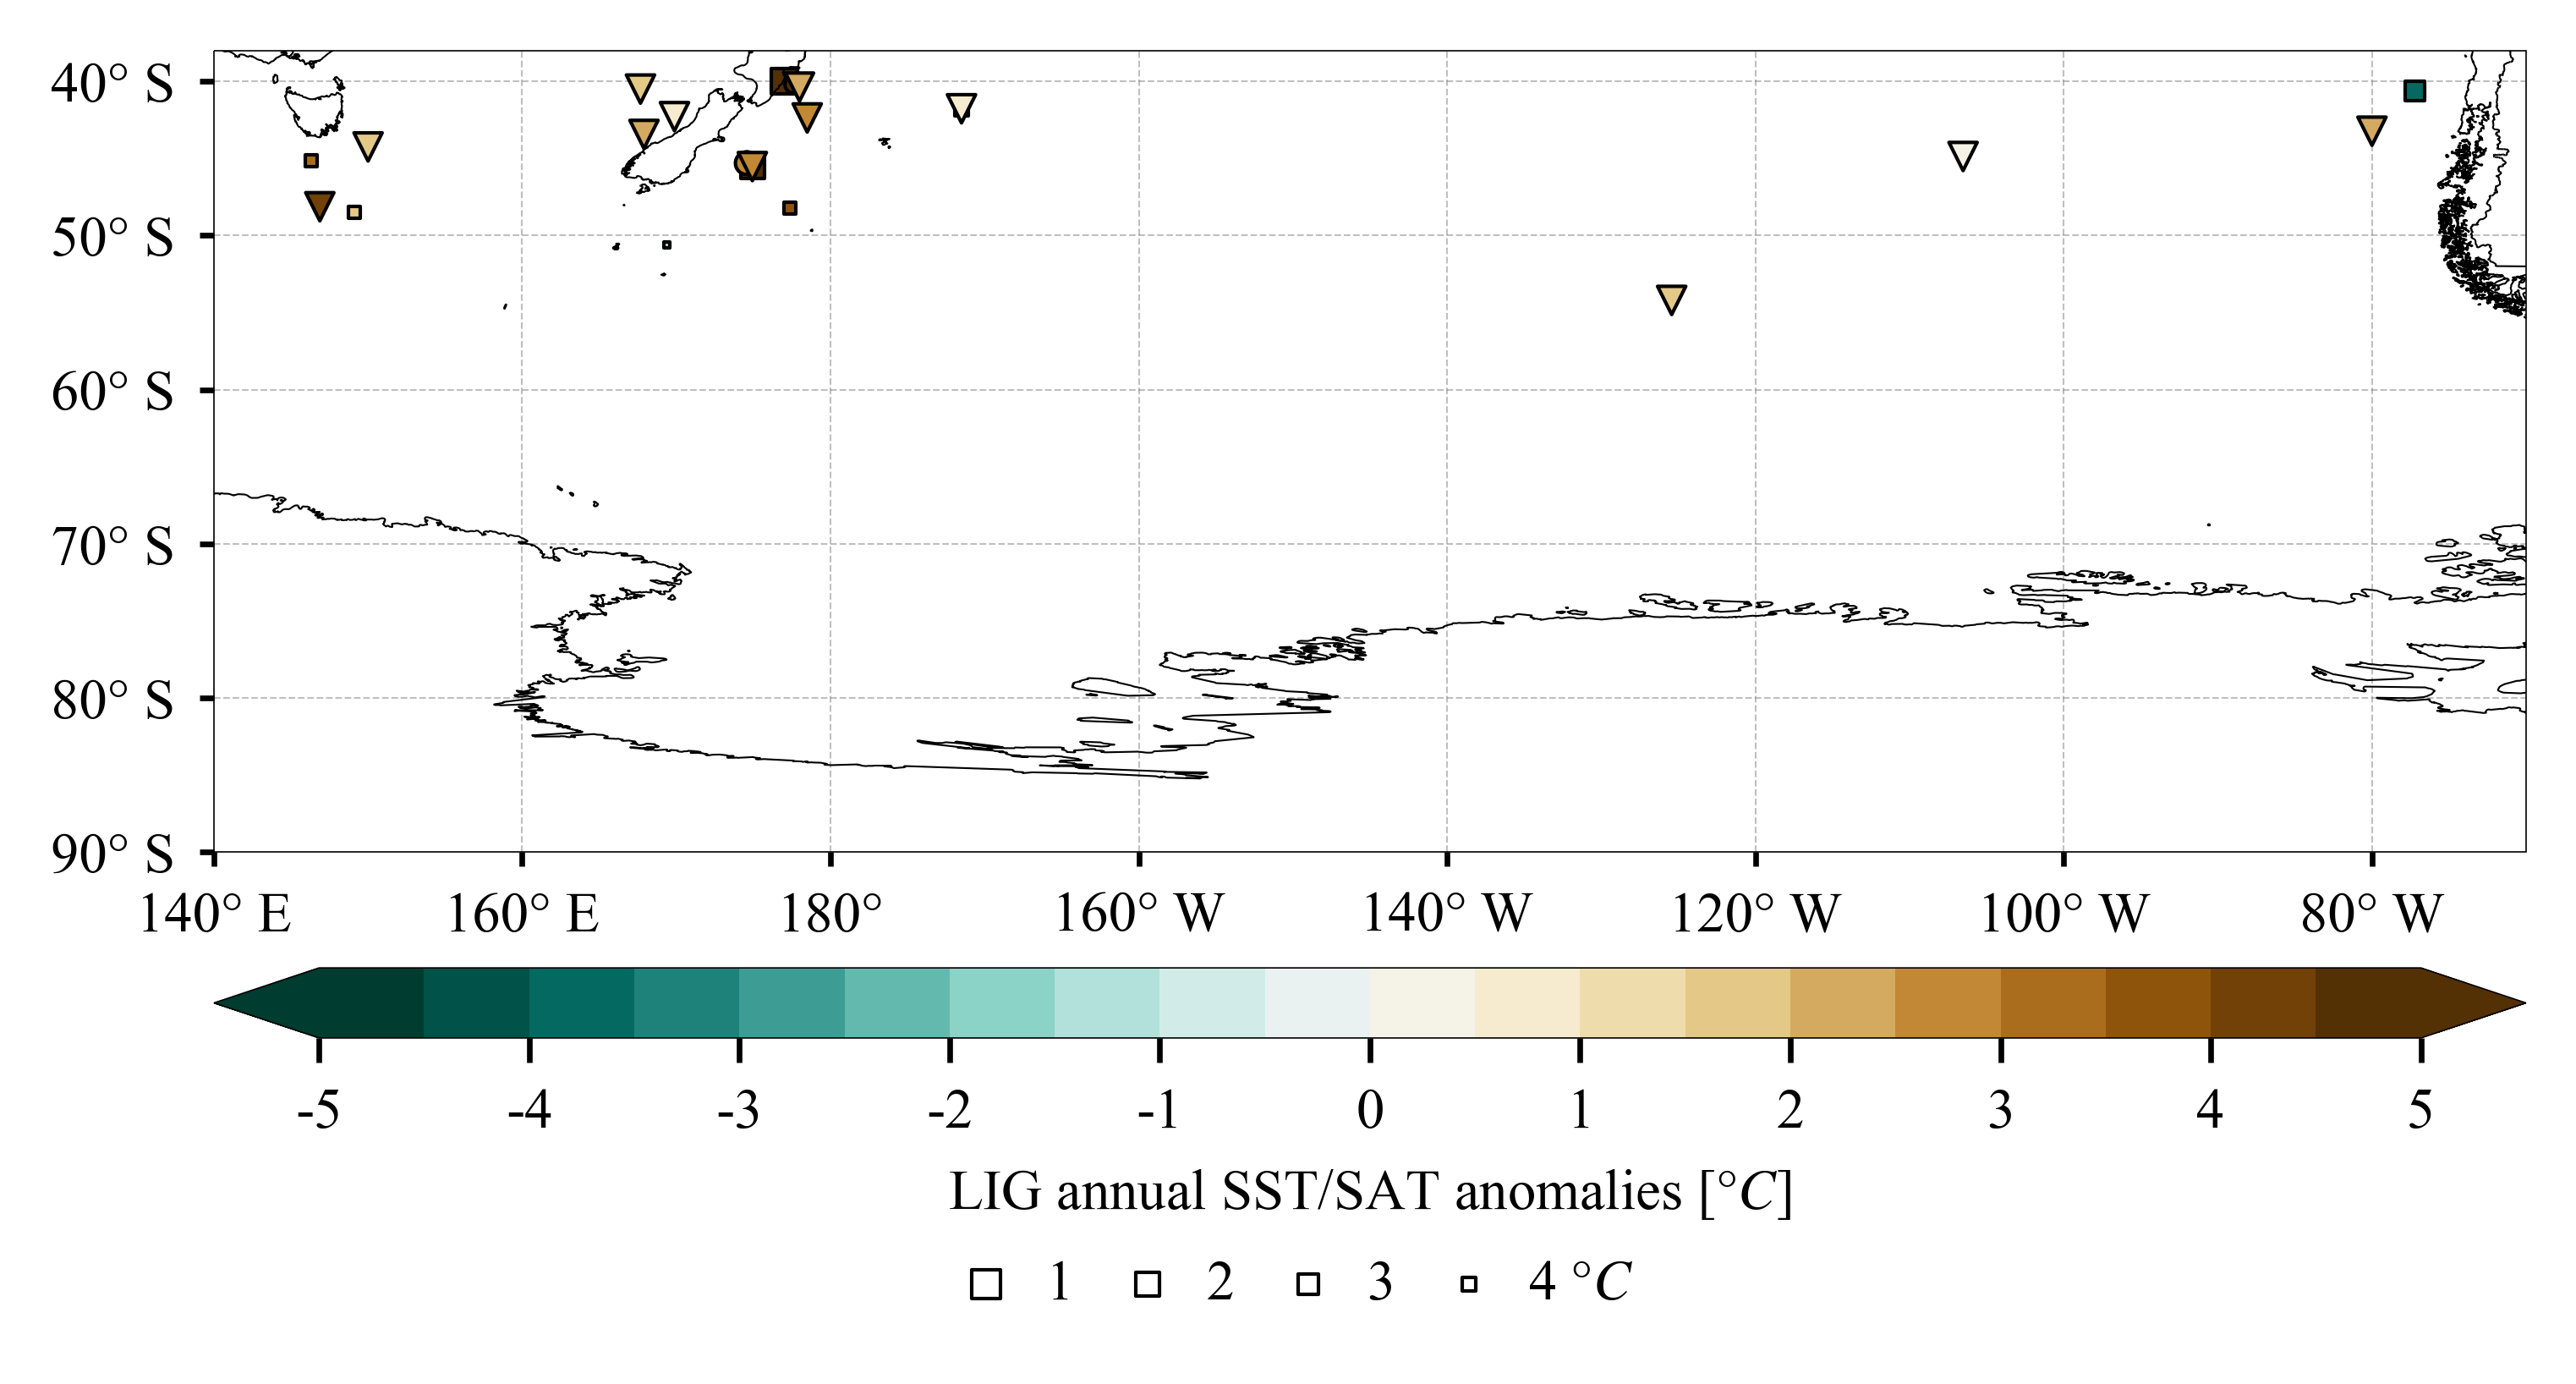

In [10]:
extent=[140, 290, -90, -38]
fig, ax = regional_plot(
    extent=extent, figsize = np.array([13, 6.4]) / 2.54,
    central_longitude = 180)

cbar_label = 'LIG annual SST/SAT anomalies [$°C$]'

pltlevel, pltticks, pltnorm, pltcmp = plt_mesh_pars(
    cm_min=-5, cm_max=5, cm_interval1=0.5, cm_interval2=1, cmap='BrBG',)

max_size = 20
scale_size = 4

# JH
ax.scatter(
    x = lig_recs['JH']['SO_ann'].Longitude,
    y = lig_recs['JH']['SO_ann'].Latitude,
    c = lig_recs['JH']['SO_ann']['127 ka SST anomaly (°C)'],
    s = max_size - scale_size * lig_recs['JH']['SO_ann']['127 ka 2σ (°C)'],
    lw=0.5, marker='s', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# EC SST
ax.scatter(
    x = lig_recs['EC']['SO_ann'].Longitude,
    y = lig_recs['EC']['SO_ann'].Latitude,
    c = lig_recs['EC']['SO_ann']['127 ka Median PIAn [°C]'],
    s = max_size - scale_size * lig_recs['EC']['SO_ann']['127 ka 2s PIAn [°C]'],
    lw=0.5, marker='o', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# EC SAT
ax.scatter(
    x = lig_recs['EC']['AIS_am'].Longitude,
    y = lig_recs['EC']['AIS_am'].Latitude,
    c = lig_recs['EC']['AIS_am']['127 ka Median PIAn [°C]'],
    s = max_size - scale_size * lig_recs['EC']['AIS_am']['127 ka 2s PIAn [°C]'],
    lw=0.5, marker='o', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# DC
plt_scatter = ax.scatter(
    x = lig_recs['DC']['annual_128'].Longitude,
    y = lig_recs['DC']['annual_128'].Latitude,
    c = lig_recs['DC']['annual_128']['sst_anom_hadisst_ann'],
    s = max_size - scale_size * 1,
    lw=0.5, marker='v', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)


l1 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 1,
    lw=0.5, edgecolors = 'black',)
l2 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 2,
    lw=0.5, edgecolors = 'black',)
l3 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 3,
    lw=0.5, edgecolors = 'black',)
l4 = plt.scatter(
    [],[], c='white', marker='s', s=max_size - scale_size * 4,
    lw=0.5, edgecolors = 'black',)
plt.legend(
    [l1, l2, l3, l4,], ['1', '2', '3', '4 $°C$'], ncol=4, frameon=False,
    loc = (0.3, -0.6), handletextpad=0.05, columnspacing=0.3,)

cbar = fig.colorbar(
    plt_scatter, ax=ax, aspect=30,
    orientation="horizontal", shrink=1, ticks=pltticks, extend='both',
    pad=0.1, fraction=0.14, format=remove_trailing_zero_pos,
    )
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xlabel(cbar_label, linespacing=1.5)


### Summer SST

Text(0.5, 0, 'LIG summer SST anomalies [$°C$]')

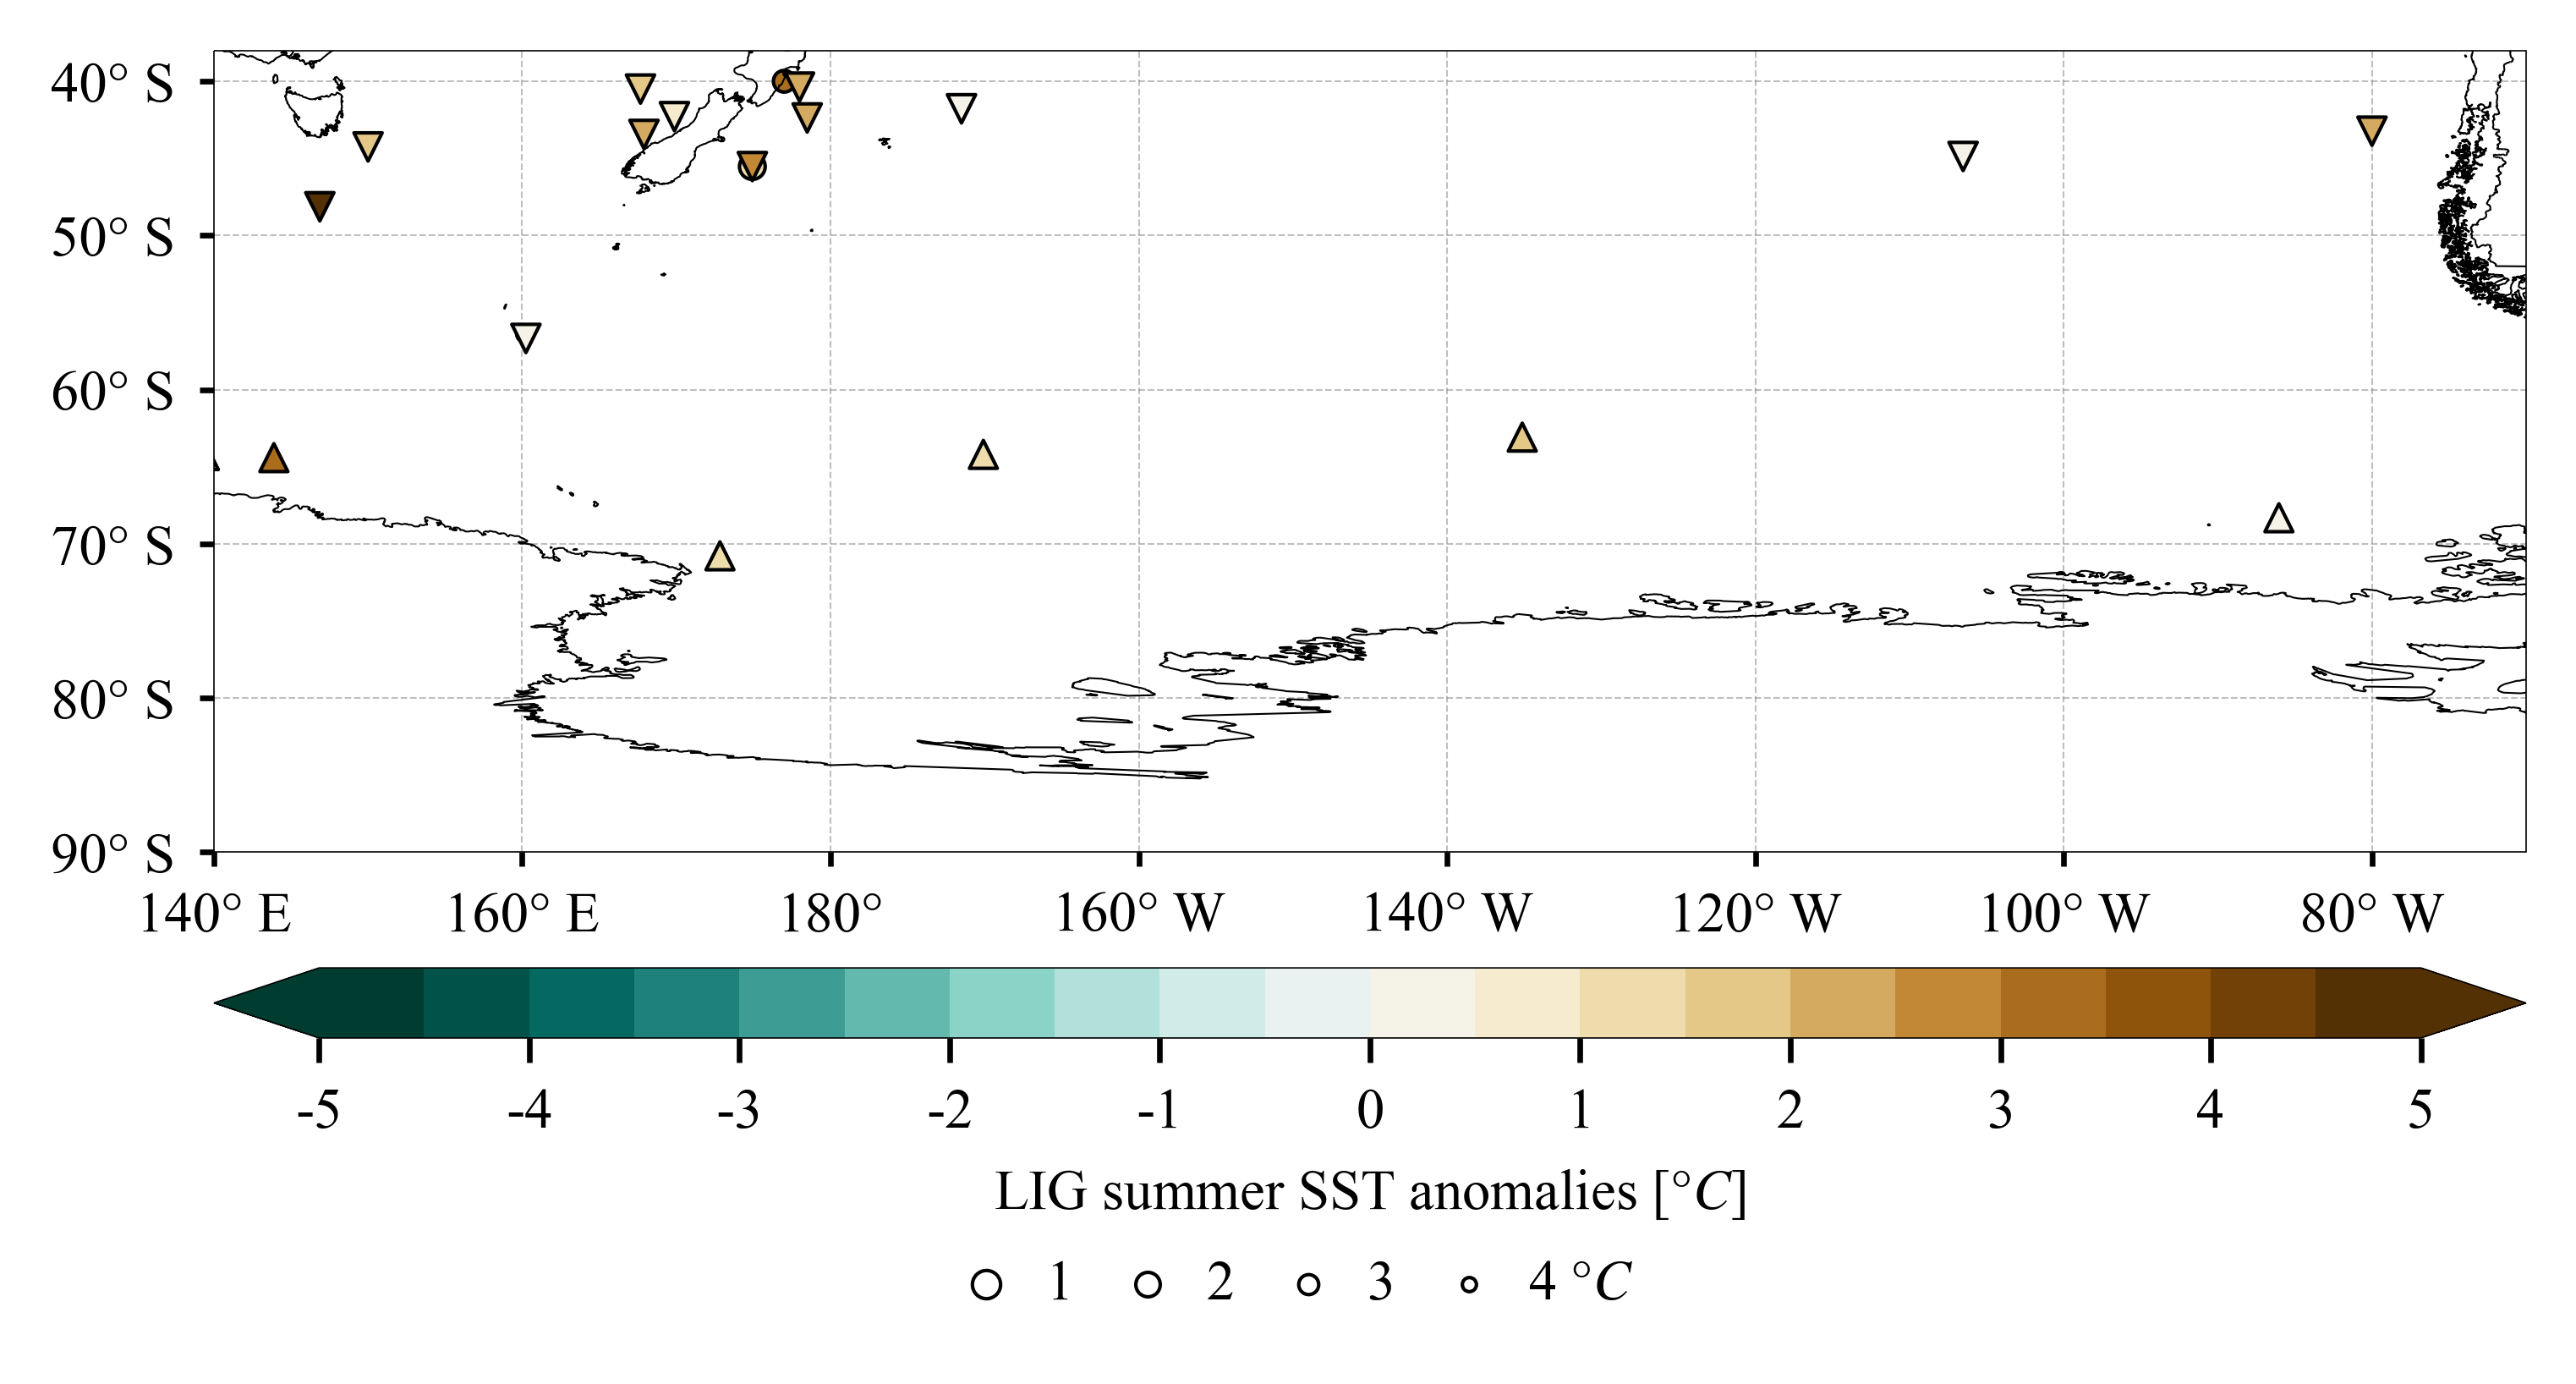

In [13]:
extent=[140, 290, -90, -38]
fig, ax = regional_plot(
    extent=extent, figsize = np.array([13, 6.4]) / 2.54,
    central_longitude = 180)

cbar_label = 'LIG summer SST anomalies [$°C$]'

pltlevel, pltticks, pltnorm, pltcmp = plt_mesh_pars(
    cm_min=-5, cm_max=5, cm_interval1=0.5, cm_interval2=1, cmap='BrBG',)

max_size = 20
scale_size = 4

# JH
ax.scatter(
    x = lig_recs['JH']['SO_jfm'].Longitude,
    y = lig_recs['JH']['SO_jfm'].Latitude,
    c = lig_recs['JH']['SO_jfm']['127 ka SST anomaly (°C)'],
    s = max_size - scale_size * lig_recs['JH']['SO_jfm']['127 ka 2σ (°C)'],
    lw=0.5, marker='s', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# EC
ax.scatter(
    x = lig_recs['EC']['SO_jfm'].Longitude,
    y = lig_recs['EC']['SO_jfm'].Latitude,
    c = lig_recs['EC']['SO_jfm']['127 ka Median PIAn [°C]'],
    s = max_size - scale_size * lig_recs['EC']['SO_jfm']['127 ka 2s PIAn [°C]'],
    lw=0.5, marker='o', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# MC
ax.scatter(
    x = lig_recs['MC']['interpolated'].Longitude,
    y = lig_recs['MC']['interpolated'].Latitude,
    c = lig_recs['MC']['interpolated']['sst_anom_hadisst_jfm'],
    s = max_size - scale_size * 1.09,
    lw=0.5, marker='^', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)

# DC
plt_scatter = ax.scatter(
    x = lig_recs['DC']['JFM_128'].Longitude,
    y = lig_recs['DC']['JFM_128'].Latitude,
    c = lig_recs['DC']['JFM_128']['sst_anom_hadisst_jfm'],
    s = max_size - scale_size * 1,
    lw=0.5, marker='v', edgecolors = 'black', zorder=2,
    norm=pltnorm, cmap=pltcmp, transform=ccrs.PlateCarree(),)


l1 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 1,
    lw=0.5, edgecolors = 'black',)
l2 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 2,
    lw=0.5, edgecolors = 'black',)
l3 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 3,
    lw=0.5, edgecolors = 'black',)
l4 = plt.scatter(
    [],[], c='white', marker='o', s=max_size - scale_size * 4,
    lw=0.5, edgecolors = 'black',)
plt.legend(
    [l1, l2, l3, l4,], ['1', '2', '3', '4 $°C$'], ncol=4, frameon=False,
    loc = (0.3, -0.6), handletextpad=0.05, columnspacing=0.3,)

cbar = fig.colorbar(
    plt_scatter, ax=ax, aspect=30,
    orientation="horizontal", shrink=1, ticks=pltticks, extend='both',
    pad=0.1, fraction=0.14, format=remove_trailing_zero_pos,
    )
cbar.ax.tick_params(labelsize=8)
cbar.ax.set_xlabel(cbar_label, linespacing=1.5)


# Plot site locations

## Antarctic plot

### Annual SST

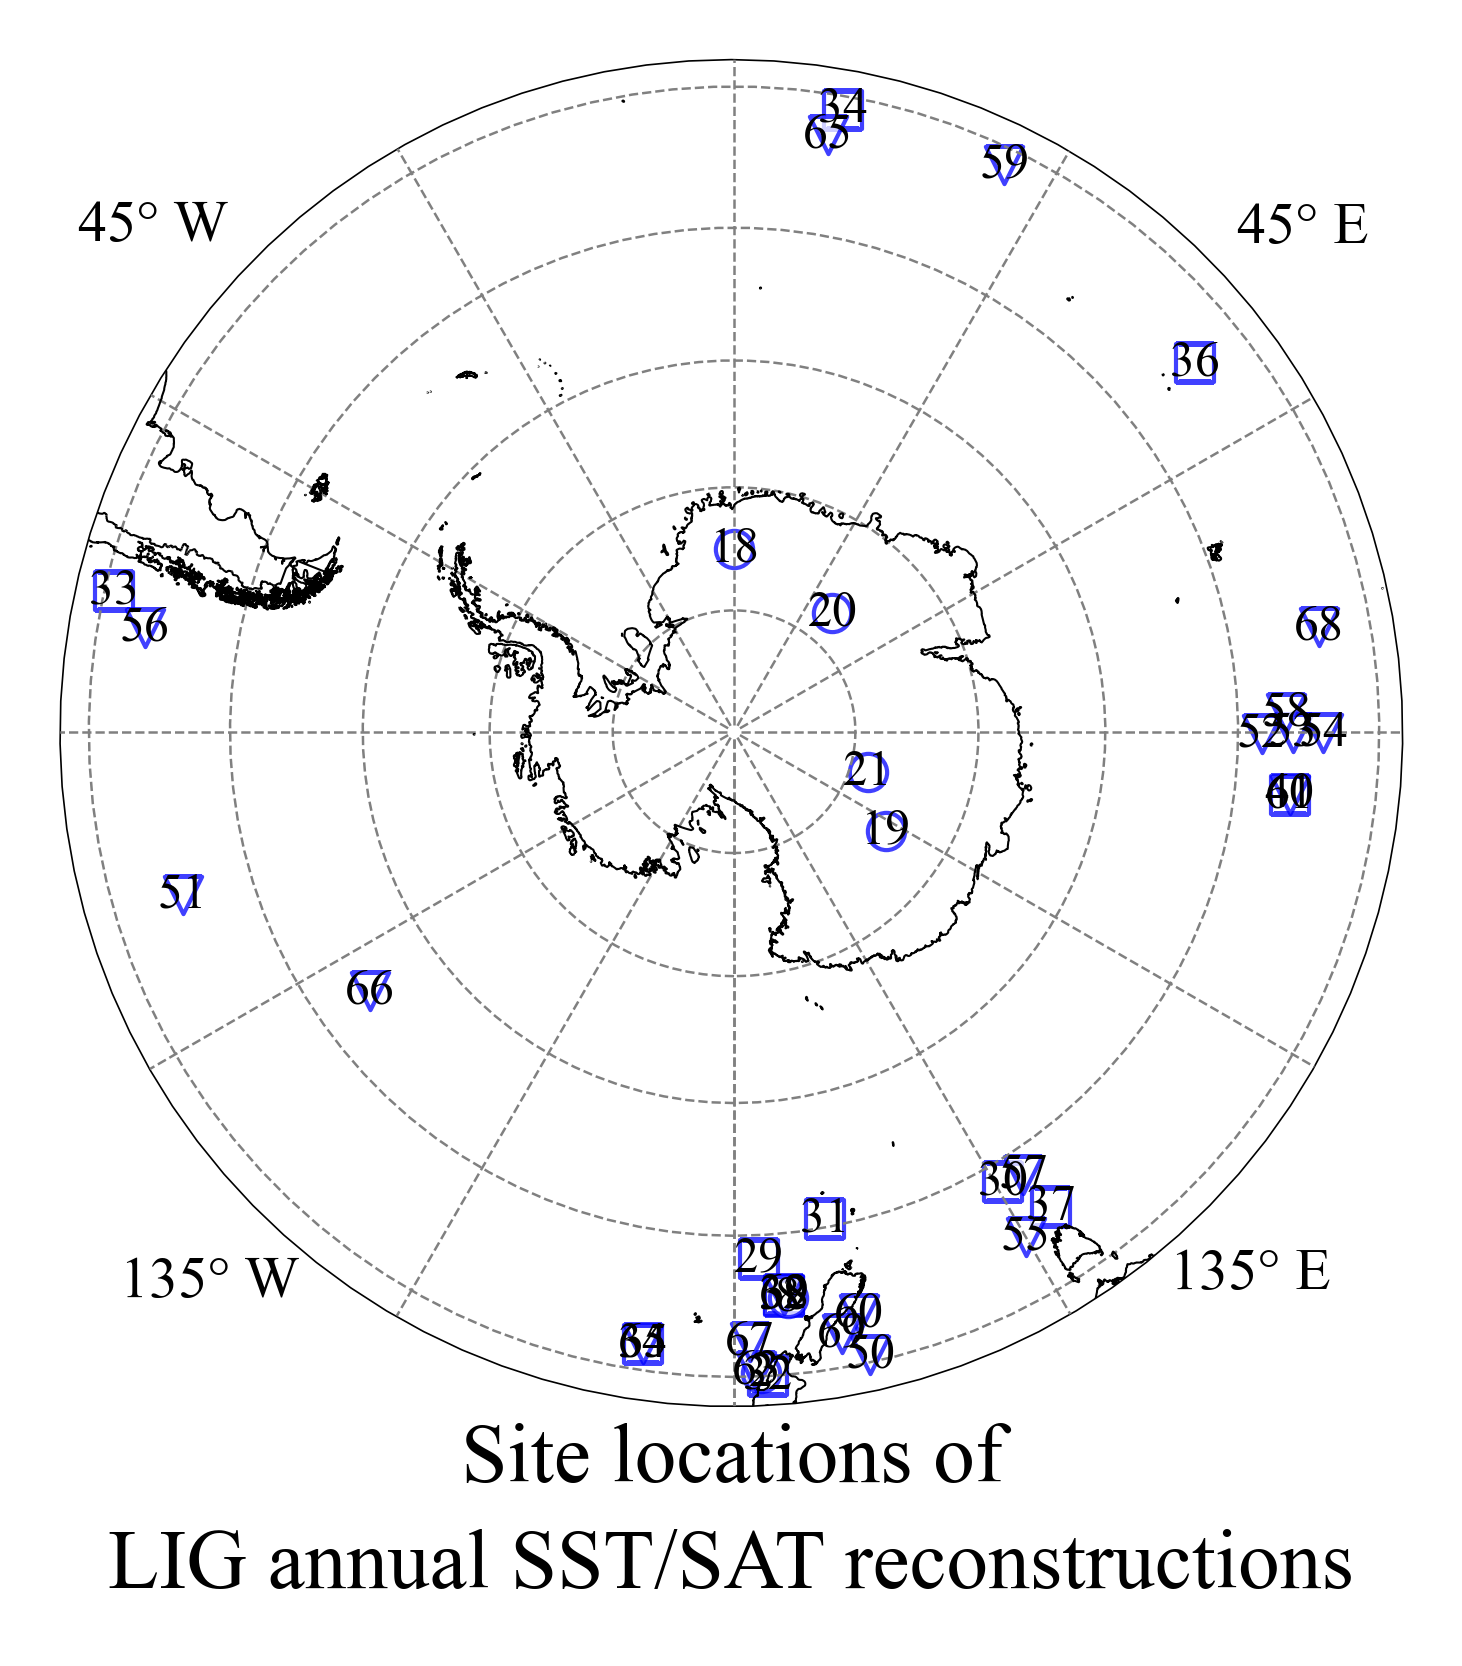

In [11]:

# datasets: symbol

fig, ax = hemisphere_plot(
    northextent=-38,
    figsize=np.array([5.8, 6.8]) / 2.54, fm_bottom=0.12)

# JH
ax.scatter(
    x = lig_recs['JH']['SO_ann'].Longitude,
    y = lig_recs['JH']['SO_ann'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='s', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# EC SST
ax.scatter(
    x = lig_recs['EC']['SO_ann'].Longitude,
    y = lig_recs['EC']['SO_ann'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='o', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# EC SAT
ax.scatter(
    x = lig_recs['EC']['AIS_am'].Longitude,
    y = lig_recs['EC']['AIS_am'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='o', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# DC
ax.scatter(
    x = lig_recs['DC']['annual_128'].Longitude,
    y = lig_recs['DC']['annual_128'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='v', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

plt.text(
    0.5, -0.08, 'Site locations of\nLIG annual SST/SAT reconstructions',
    horizontalalignment='center', verticalalignment='center',
    transform=ax.transAxes, linespacing=1.5)

'''
for itext in range(len(lig_datasubsets['annual_sst']['No.'])):
    ax.text(
        lig_datasubsets['annual_sst']['Longitude'].iloc[itext],
        lig_datasubsets['annual_sst']['Latitude'].iloc[itext],
        lig_datasubsets['annual_sst']['No.'].iloc[itext],
        horizontalalignment='center', verticalalignment='center',
        transform=ccrs.PlateCarree(), size=6,
    )

for itext in range(len(lig_datasubsets['annual_sat']['No.'])):
    ax.text(
        lig_datasubsets['annual_sat']['Longitude'].iloc[itext],
        lig_datasubsets['annual_sat']['Latitude'].iloc[itext],
        lig_datasubsets['annual_sat']['No.'].iloc[itext],
        horizontalalignment='center', verticalalignment='center',
        transform=ccrs.PlateCarree(), size=6,
    )
'''

output_png = 'figures/7_lig/7.0_sim_rec/7.0.3_rec/7.0.3.1_rec_site_locations/7.0.3.1 locations of annual sst_sat reconstructions.pdf'
fig.savefig(output_png)


### Summer SST

Text(0.5, -0.05, 'Site locations of LIG summer SST reconstructions')

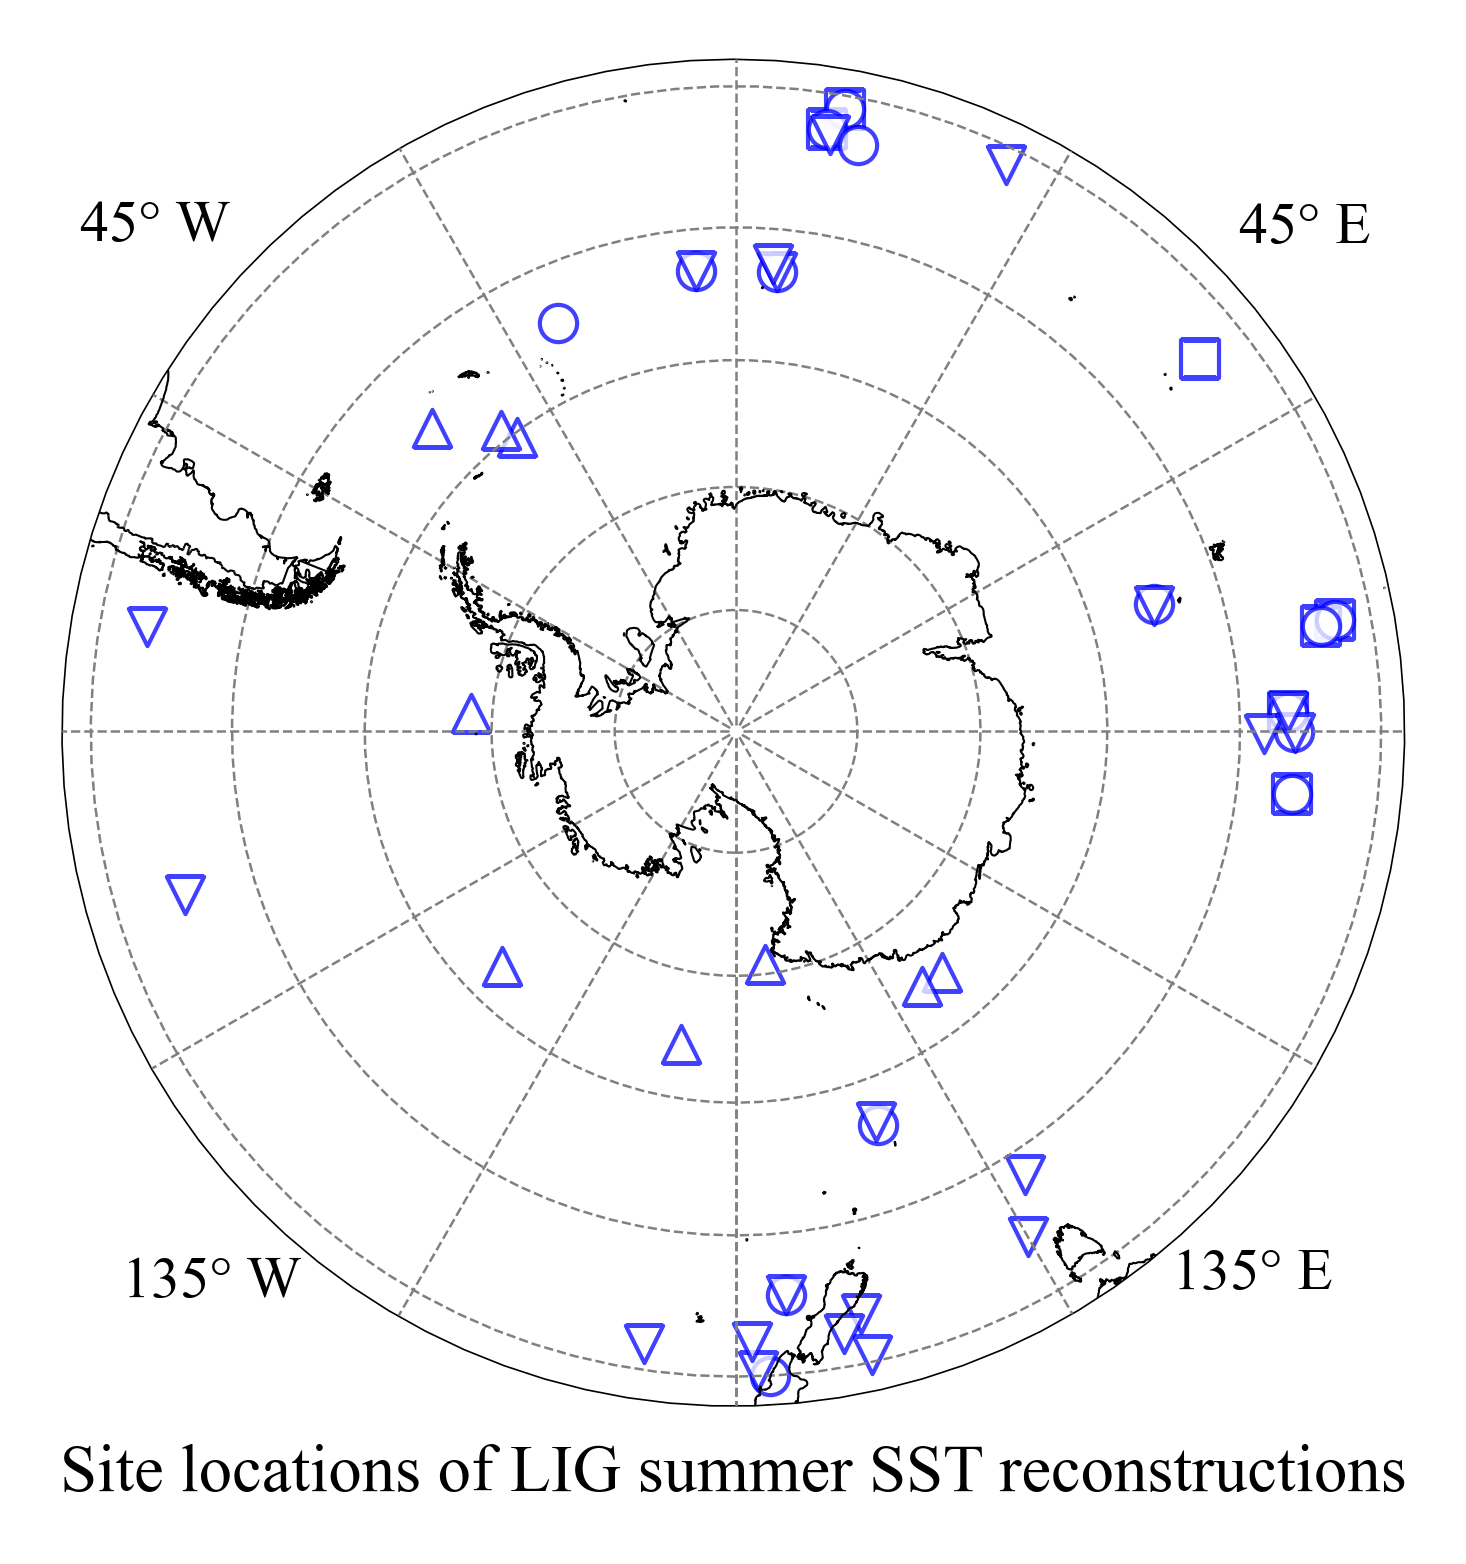

In [23]:
fig, ax = hemisphere_plot(northextent=-38)

# JH
ax.scatter(
    x = lig_recs['JH']['SO_jfm'].Longitude,
    y = lig_recs['JH']['SO_jfm'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='s', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# EC
ax.scatter(
    x = lig_recs['EC']['SO_jfm'].Longitude,
    y = lig_recs['EC']['SO_jfm'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='o', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# MC
ax.scatter(
    x = lig_recs['MC']['interpolated'].Longitude,
    y = lig_recs['MC']['interpolated'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='^', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# DC
ax.scatter(
    x = lig_recs['DC']['JFM_128'].Longitude,
    y = lig_recs['DC']['JFM_128'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='v', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

plt.text(
    0.5, -0.05, 'Site locations of LIG summer SST reconstructions',
    horizontalalignment='center', verticalalignment='center',
    transform=ax.transAxes)


## Atlantic sector plot

In [34]:
symbol_size = 25

### Annual SST

Text(0.5, -0.16, 'Site locations of LIG annual SST/SAT reconstructions')

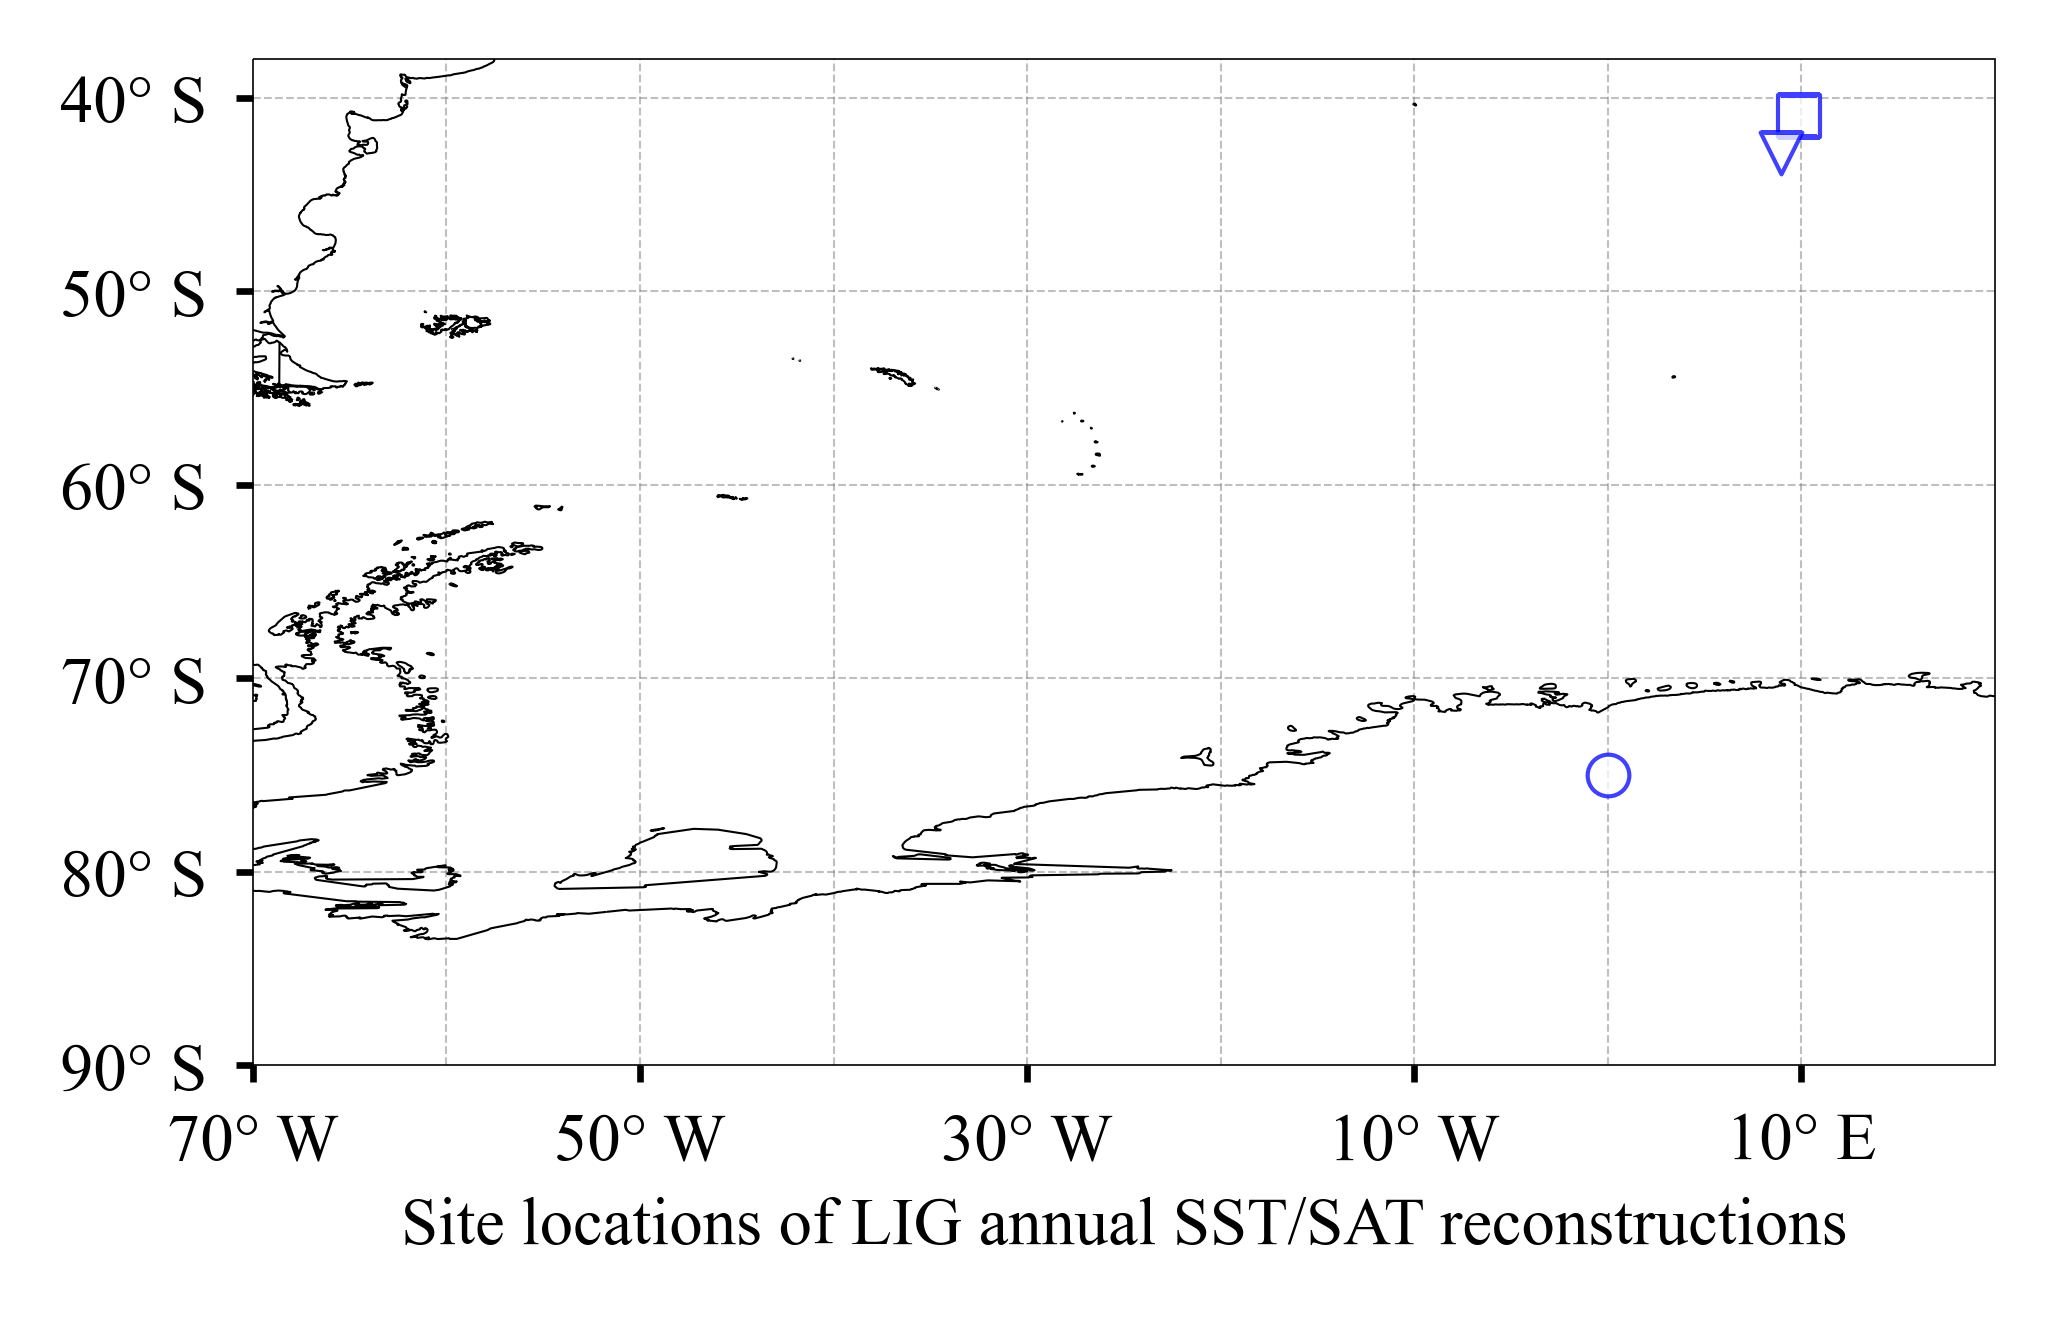

In [29]:
extent=[-70, 20, -90, -38]
fig, ax = regional_plot(extent=extent, figsize = np.array([8.8, 6.6]) / 2.54)

# JH
ax.scatter(
    x = lig_recs['JH']['SO_ann'].Longitude,
    y = lig_recs['JH']['SO_ann'].Latitude,
    c = 'white', s = symbol_size,
    lw=0.5, marker='s', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# EC SST
ax.scatter(
    x = lig_recs['EC']['SO_ann'].Longitude,
    y = lig_recs['EC']['SO_ann'].Latitude,
    c = 'white', s = symbol_size,
    lw=0.5, marker='o', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# EC SAT
ax.scatter(
    x = lig_recs['EC']['AIS_am'].Longitude,
    y = lig_recs['EC']['AIS_am'].Latitude,
    c = 'white', s = symbol_size,
    lw=0.5, marker='o', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# DC
plt_scatter = ax.scatter(
    x = lig_recs['DC']['annual_128'].Longitude,
    y = lig_recs['DC']['annual_128'].Latitude,
    c = 'white', s = symbol_size,
    lw=0.5, marker='v', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

plt.text(
    0.5, -0.16, 'Site locations of LIG annual SST/SAT reconstructions',
    horizontalalignment='center', verticalalignment='center',
    transform=ax.transAxes)

### Summer SST

Text(0.5, -0.16, 'Site locations of LIG summer SST reconstructions')

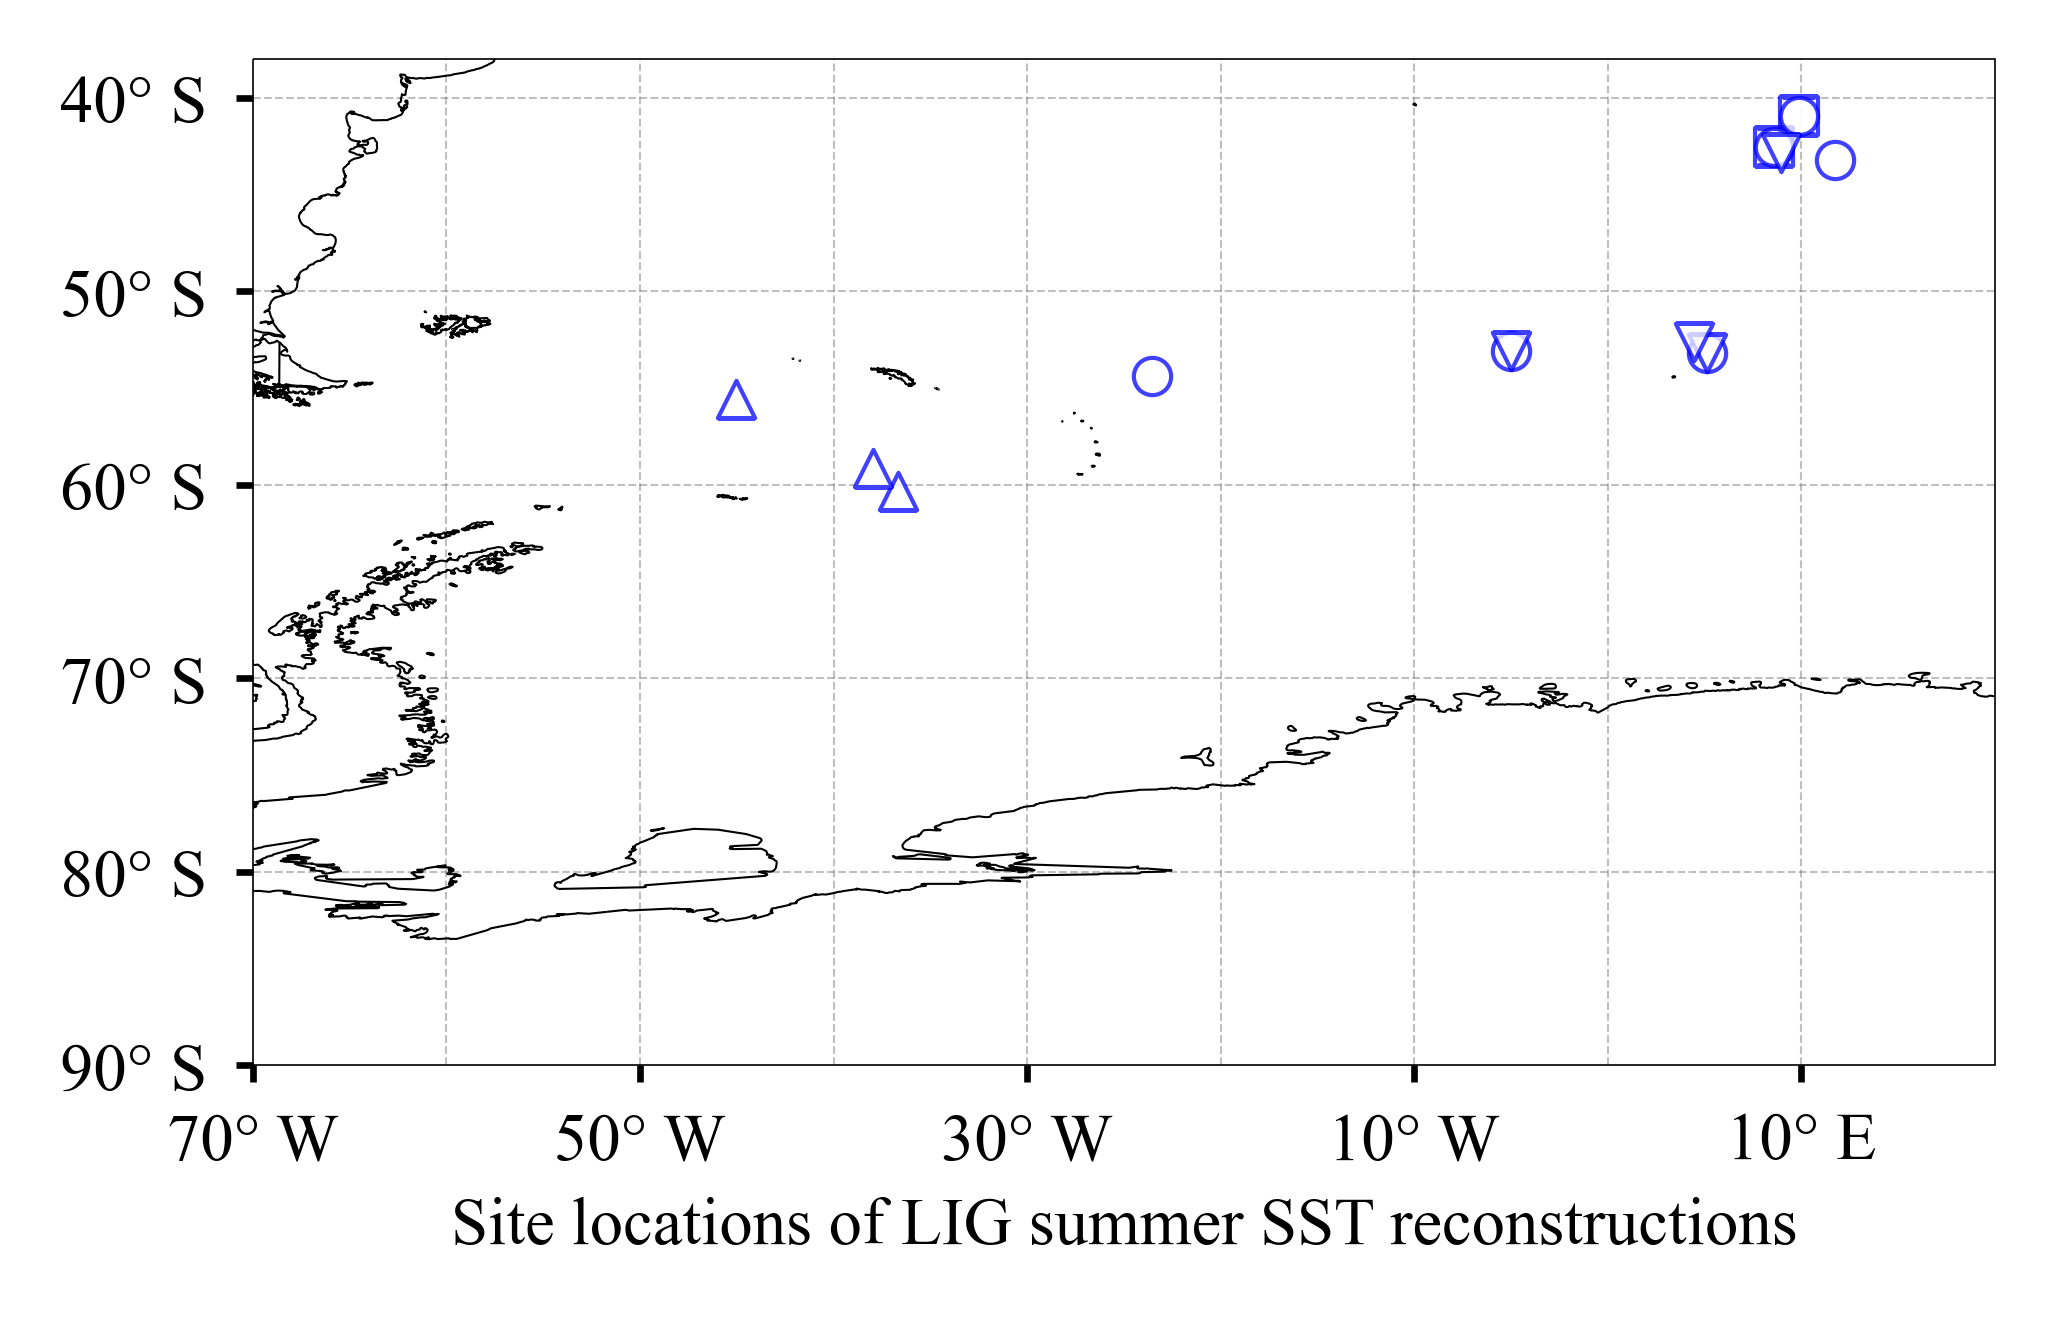

In [35]:

extent=[-70, 20, -90, -38]
fig, ax = regional_plot(extent=extent, figsize = np.array([8.8, 6.6]) / 2.54)

# JH
ax.scatter(
    x = lig_recs['JH']['SO_jfm'].Longitude,
    y = lig_recs['JH']['SO_jfm'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='s', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# EC
ax.scatter(
    x = lig_recs['EC']['SO_jfm'].Longitude,
    y = lig_recs['EC']['SO_jfm'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='o', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# MC
ax.scatter(
    x = lig_recs['MC']['interpolated'].Longitude,
    y = lig_recs['MC']['interpolated'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='^', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# DC
plt_scatter = ax.scatter(
    x = lig_recs['DC']['JFM_128'].Longitude,
    y = lig_recs['DC']['JFM_128'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='v', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

plt.text(
    0.5, -0.16, 'Site locations of LIG summer SST reconstructions',
    horizontalalignment='center', verticalalignment='center',
    transform=ax.transAxes)


## Indian sector plot

In [36]:
symbol_size = 25

### Annual SST

Text(0.5, -0.16, 'Site locations of LIG annual SST/SAT reconstructions')

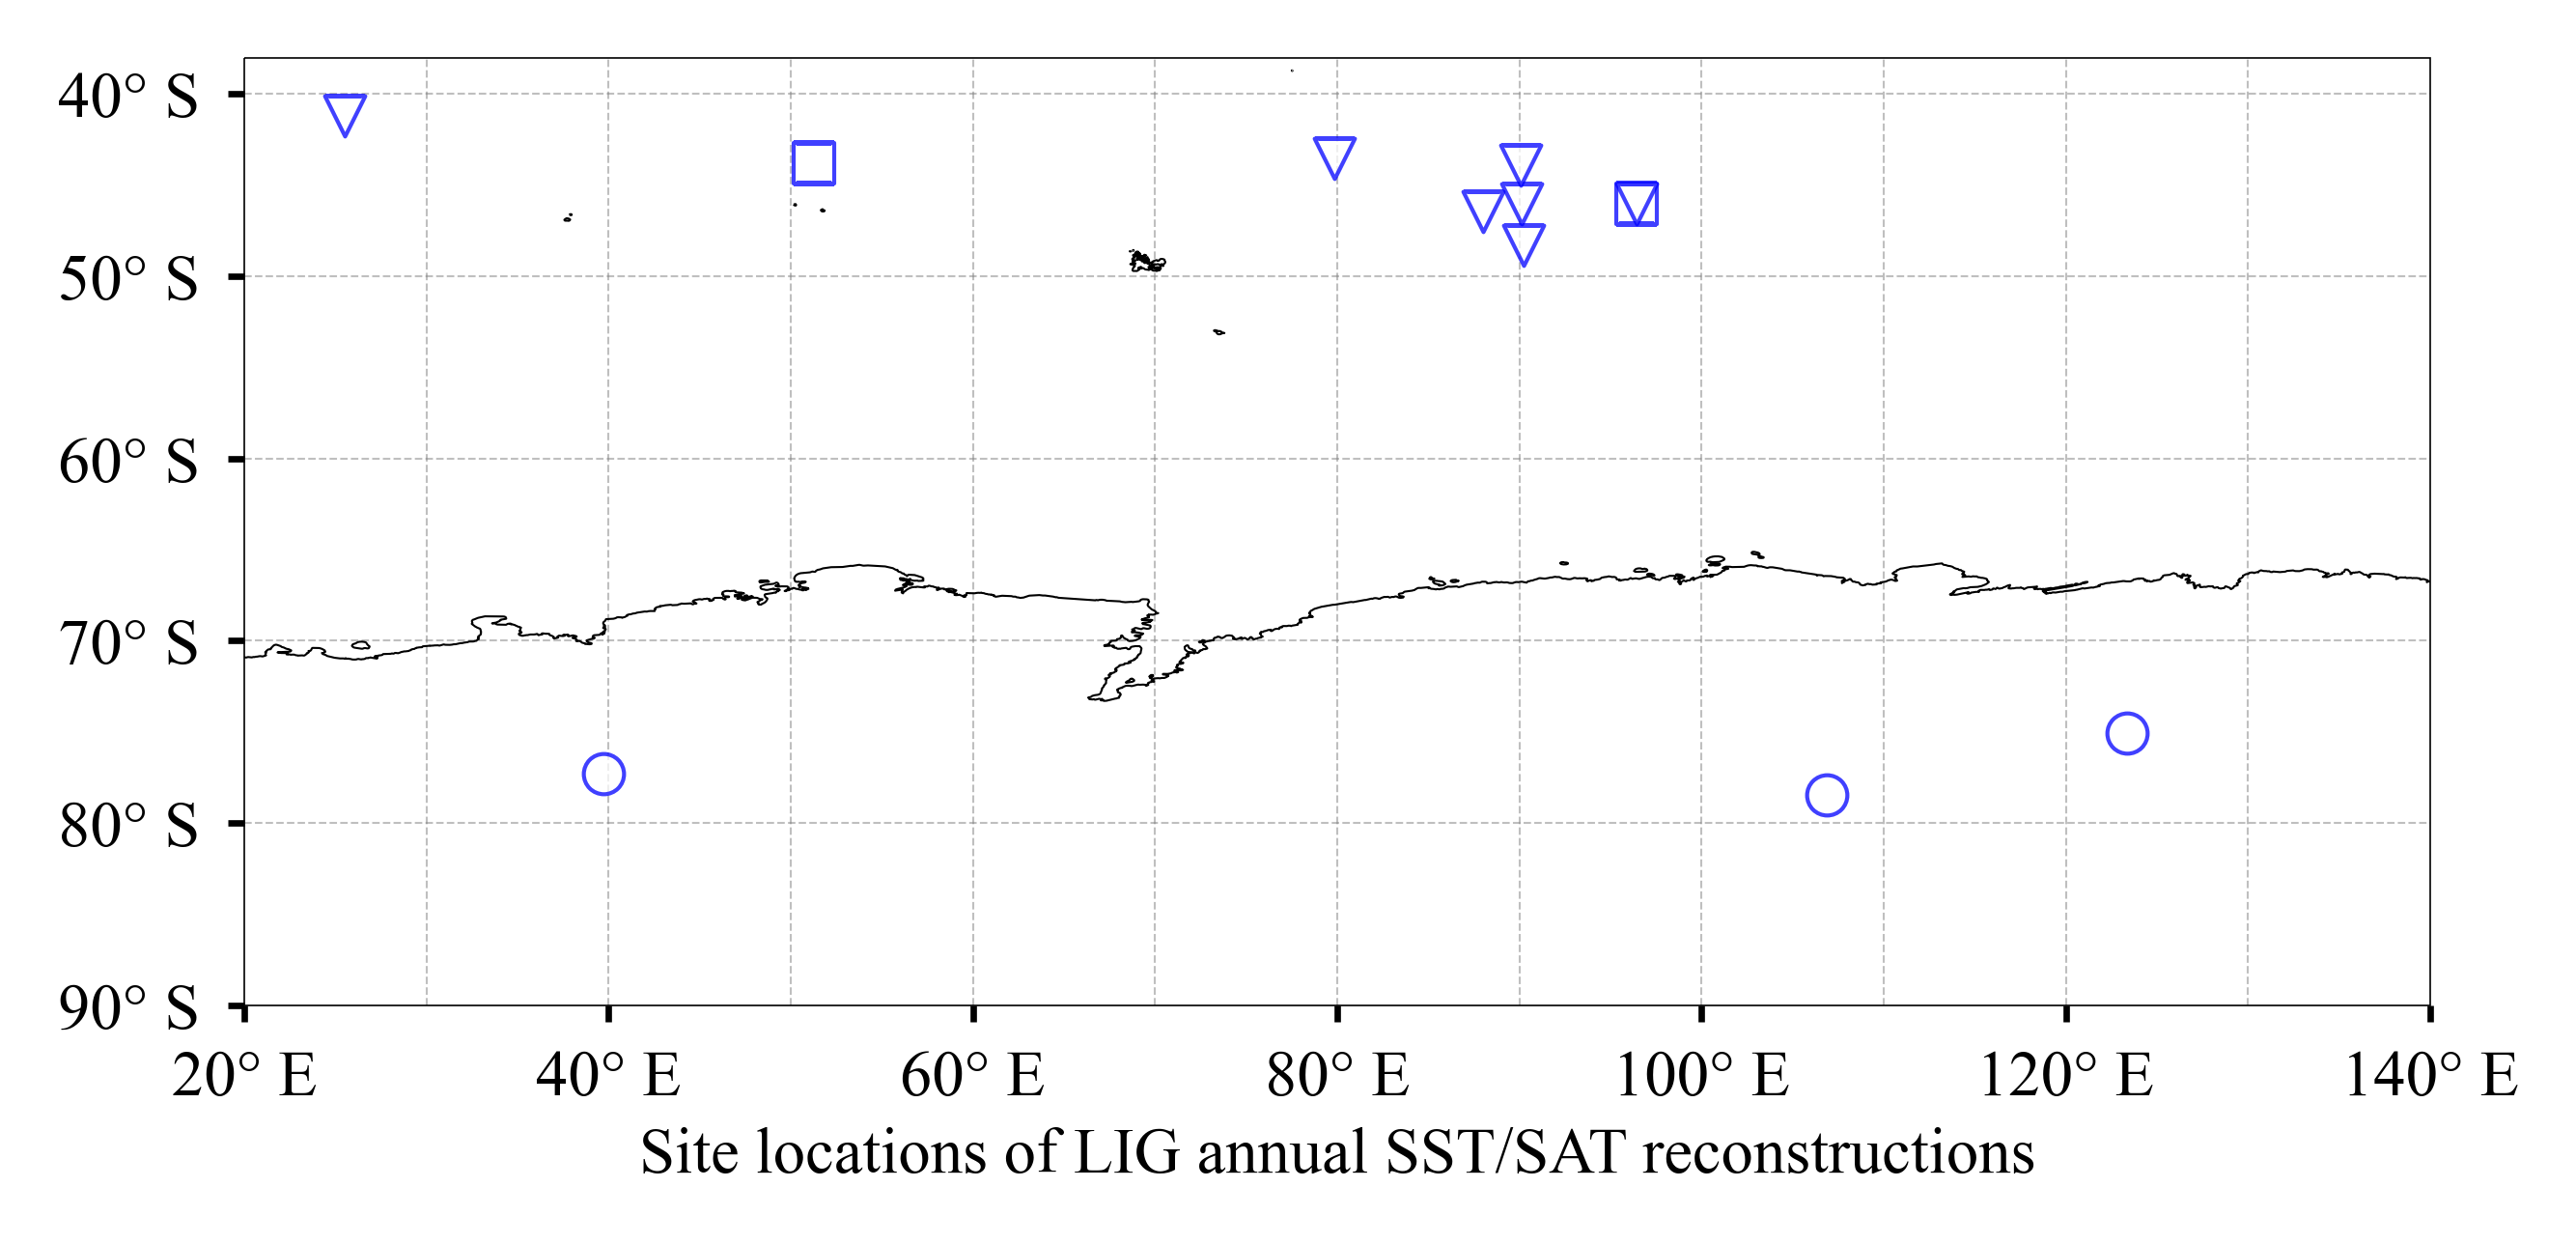

In [38]:
extent=[20, 140, -90, -38]
fig, ax = regional_plot(extent=extent, figsize = np.array([11.4, 6.4]) / 2.54)

# JH
ax.scatter(
    x = lig_recs['JH']['SO_ann'].Longitude,
    y = lig_recs['JH']['SO_ann'].Latitude,
    c = 'white', s = symbol_size,
    lw=0.5, marker='s', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# EC SST
ax.scatter(
    x = lig_recs['EC']['SO_ann'].Longitude,
    y = lig_recs['EC']['SO_ann'].Latitude,
    c = 'white', s = symbol_size,
    lw=0.5, marker='o', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# EC SAT
ax.scatter(
    x = lig_recs['EC']['AIS_am'].Longitude,
    y = lig_recs['EC']['AIS_am'].Latitude,
    c = 'white', s = symbol_size,
    lw=0.5, marker='o', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# DC
plt_scatter = ax.scatter(
    x = lig_recs['DC']['annual_128'].Longitude,
    y = lig_recs['DC']['annual_128'].Latitude,
    c = 'white', s = symbol_size,
    lw=0.5, marker='v', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

plt.text(
    0.5, -0.16, 'Site locations of LIG annual SST/SAT reconstructions',
    horizontalalignment='center', verticalalignment='center',
    transform=ax.transAxes)

### Summer SST

Text(0.5, -0.16, 'Site locations of LIG summer SST reconstructions')

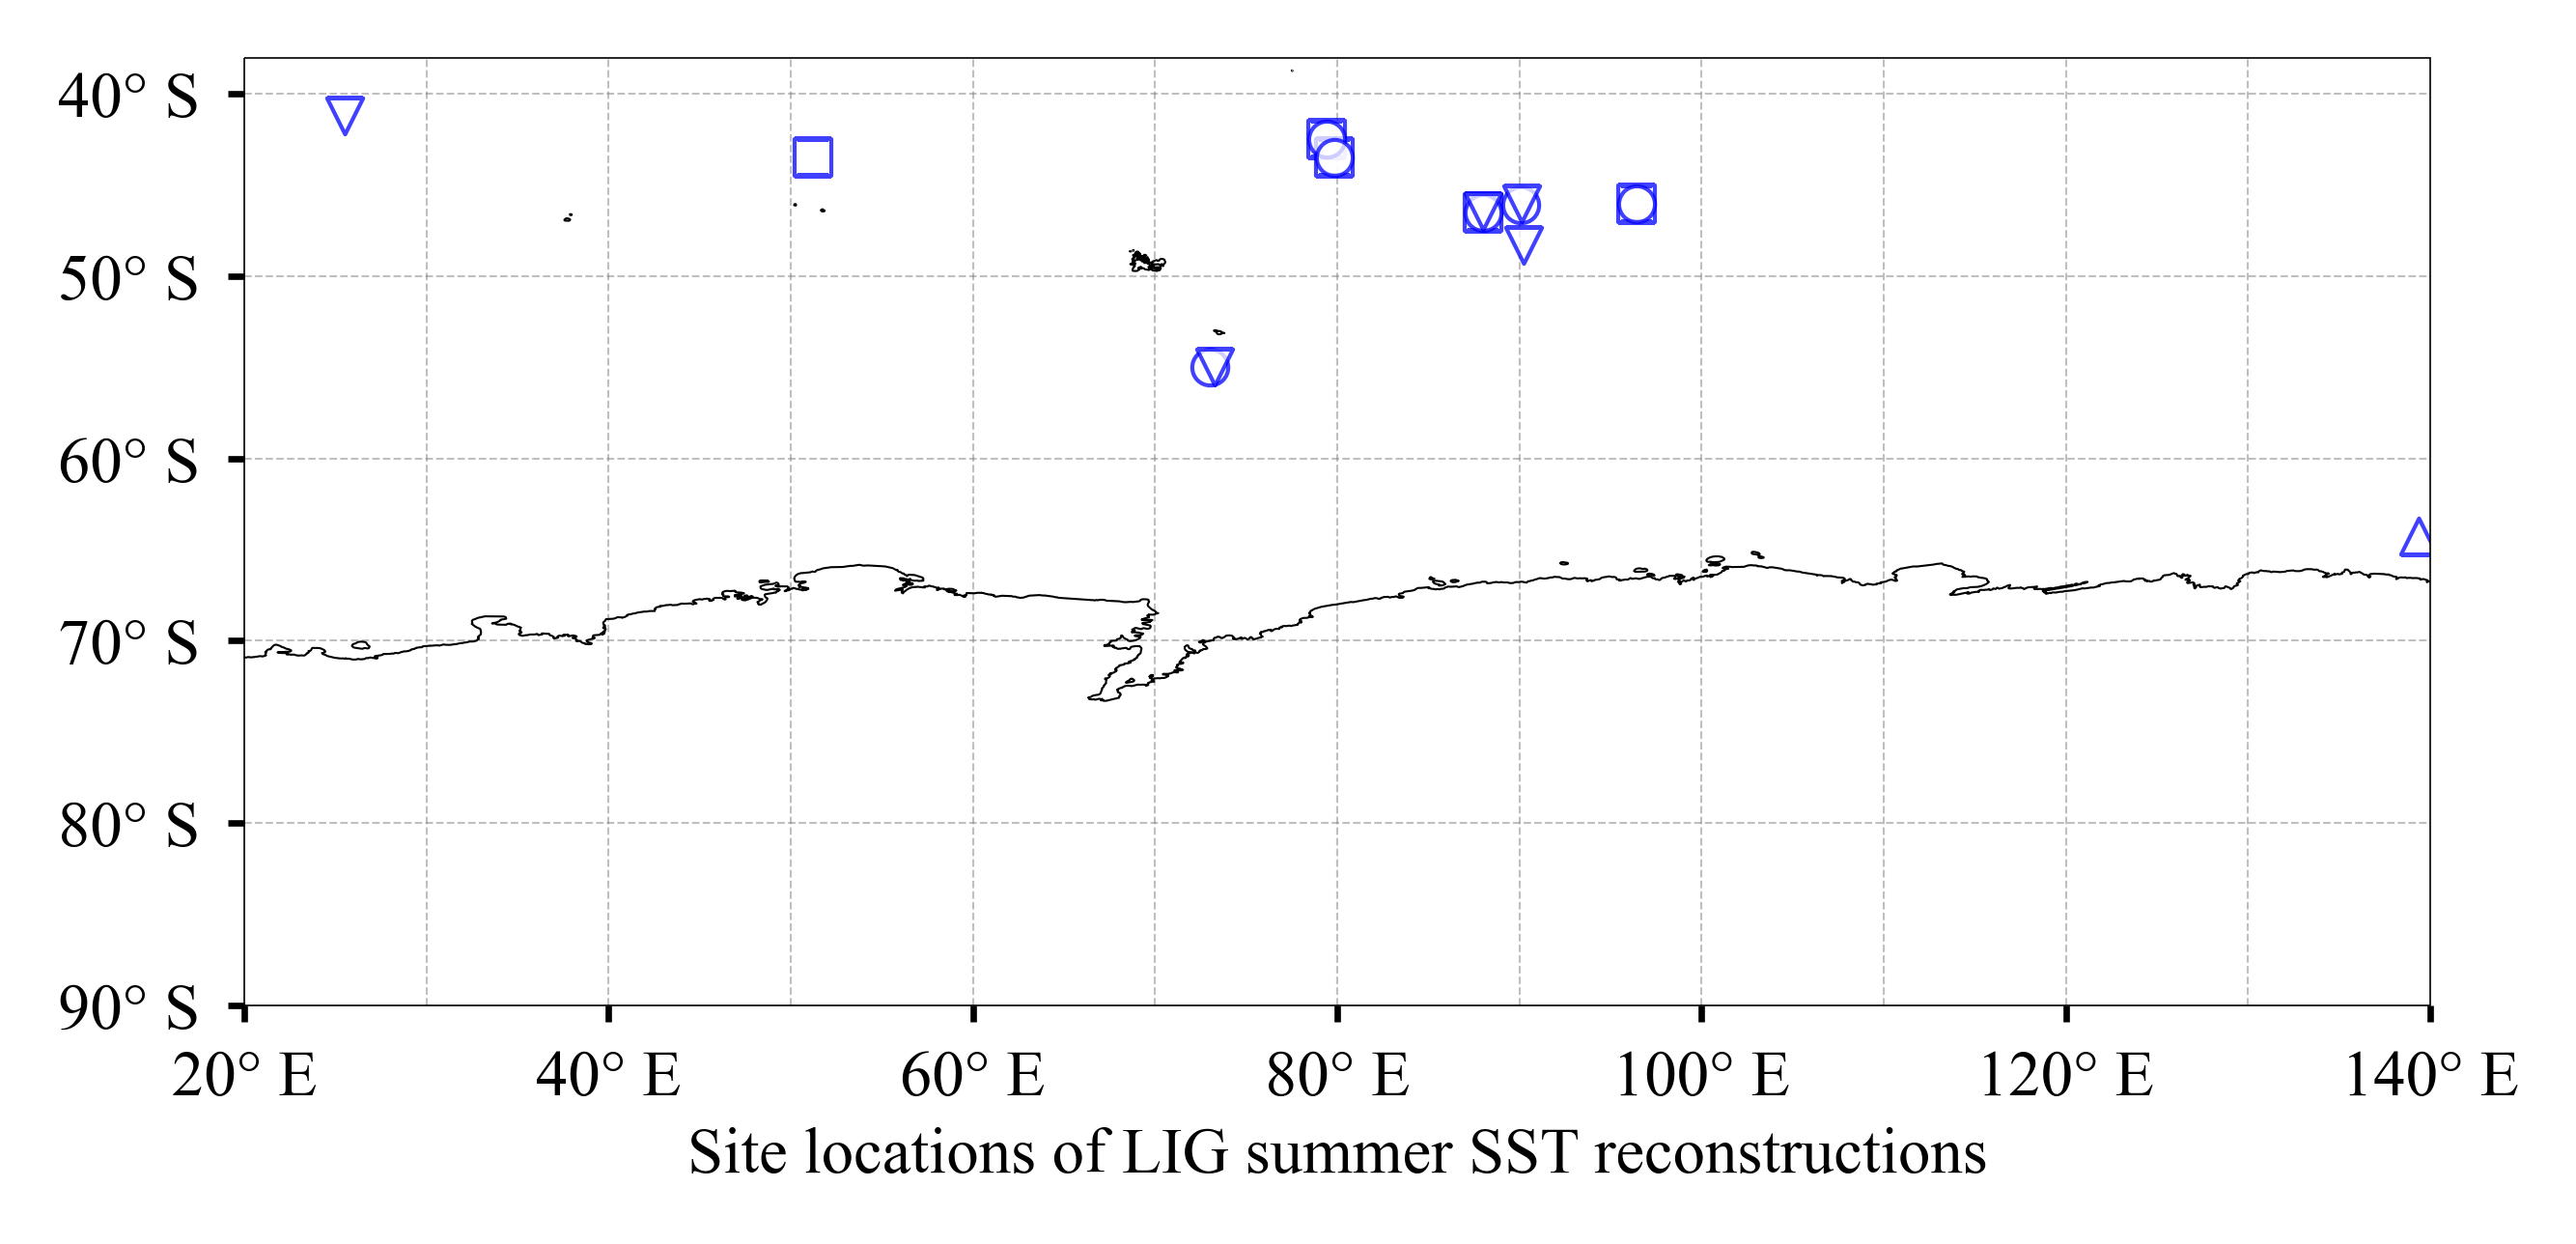

In [39]:

extent=[20, 140, -90, -38]
fig, ax = regional_plot(extent=extent, figsize = np.array([11.4, 6.4]) / 2.54)

# JH
ax.scatter(
    x = lig_recs['JH']['SO_jfm'].Longitude,
    y = lig_recs['JH']['SO_jfm'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='s', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# EC
ax.scatter(
    x = lig_recs['EC']['SO_jfm'].Longitude,
    y = lig_recs['EC']['SO_jfm'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='o', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# MC
ax.scatter(
    x = lig_recs['MC']['interpolated'].Longitude,
    y = lig_recs['MC']['interpolated'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='^', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# DC
plt_scatter = ax.scatter(
    x = lig_recs['DC']['JFM_128'].Longitude,
    y = lig_recs['DC']['JFM_128'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='v', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

plt.text(
    0.5, -0.16, 'Site locations of LIG summer SST reconstructions',
    horizontalalignment='center', verticalalignment='center',
    transform=ax.transAxes)


## Pacific sector plot

In [40]:
symbol_size = 25

### Annual SST

Text(0.5, -0.16, 'Site locations of LIG annual SST/SAT reconstructions')

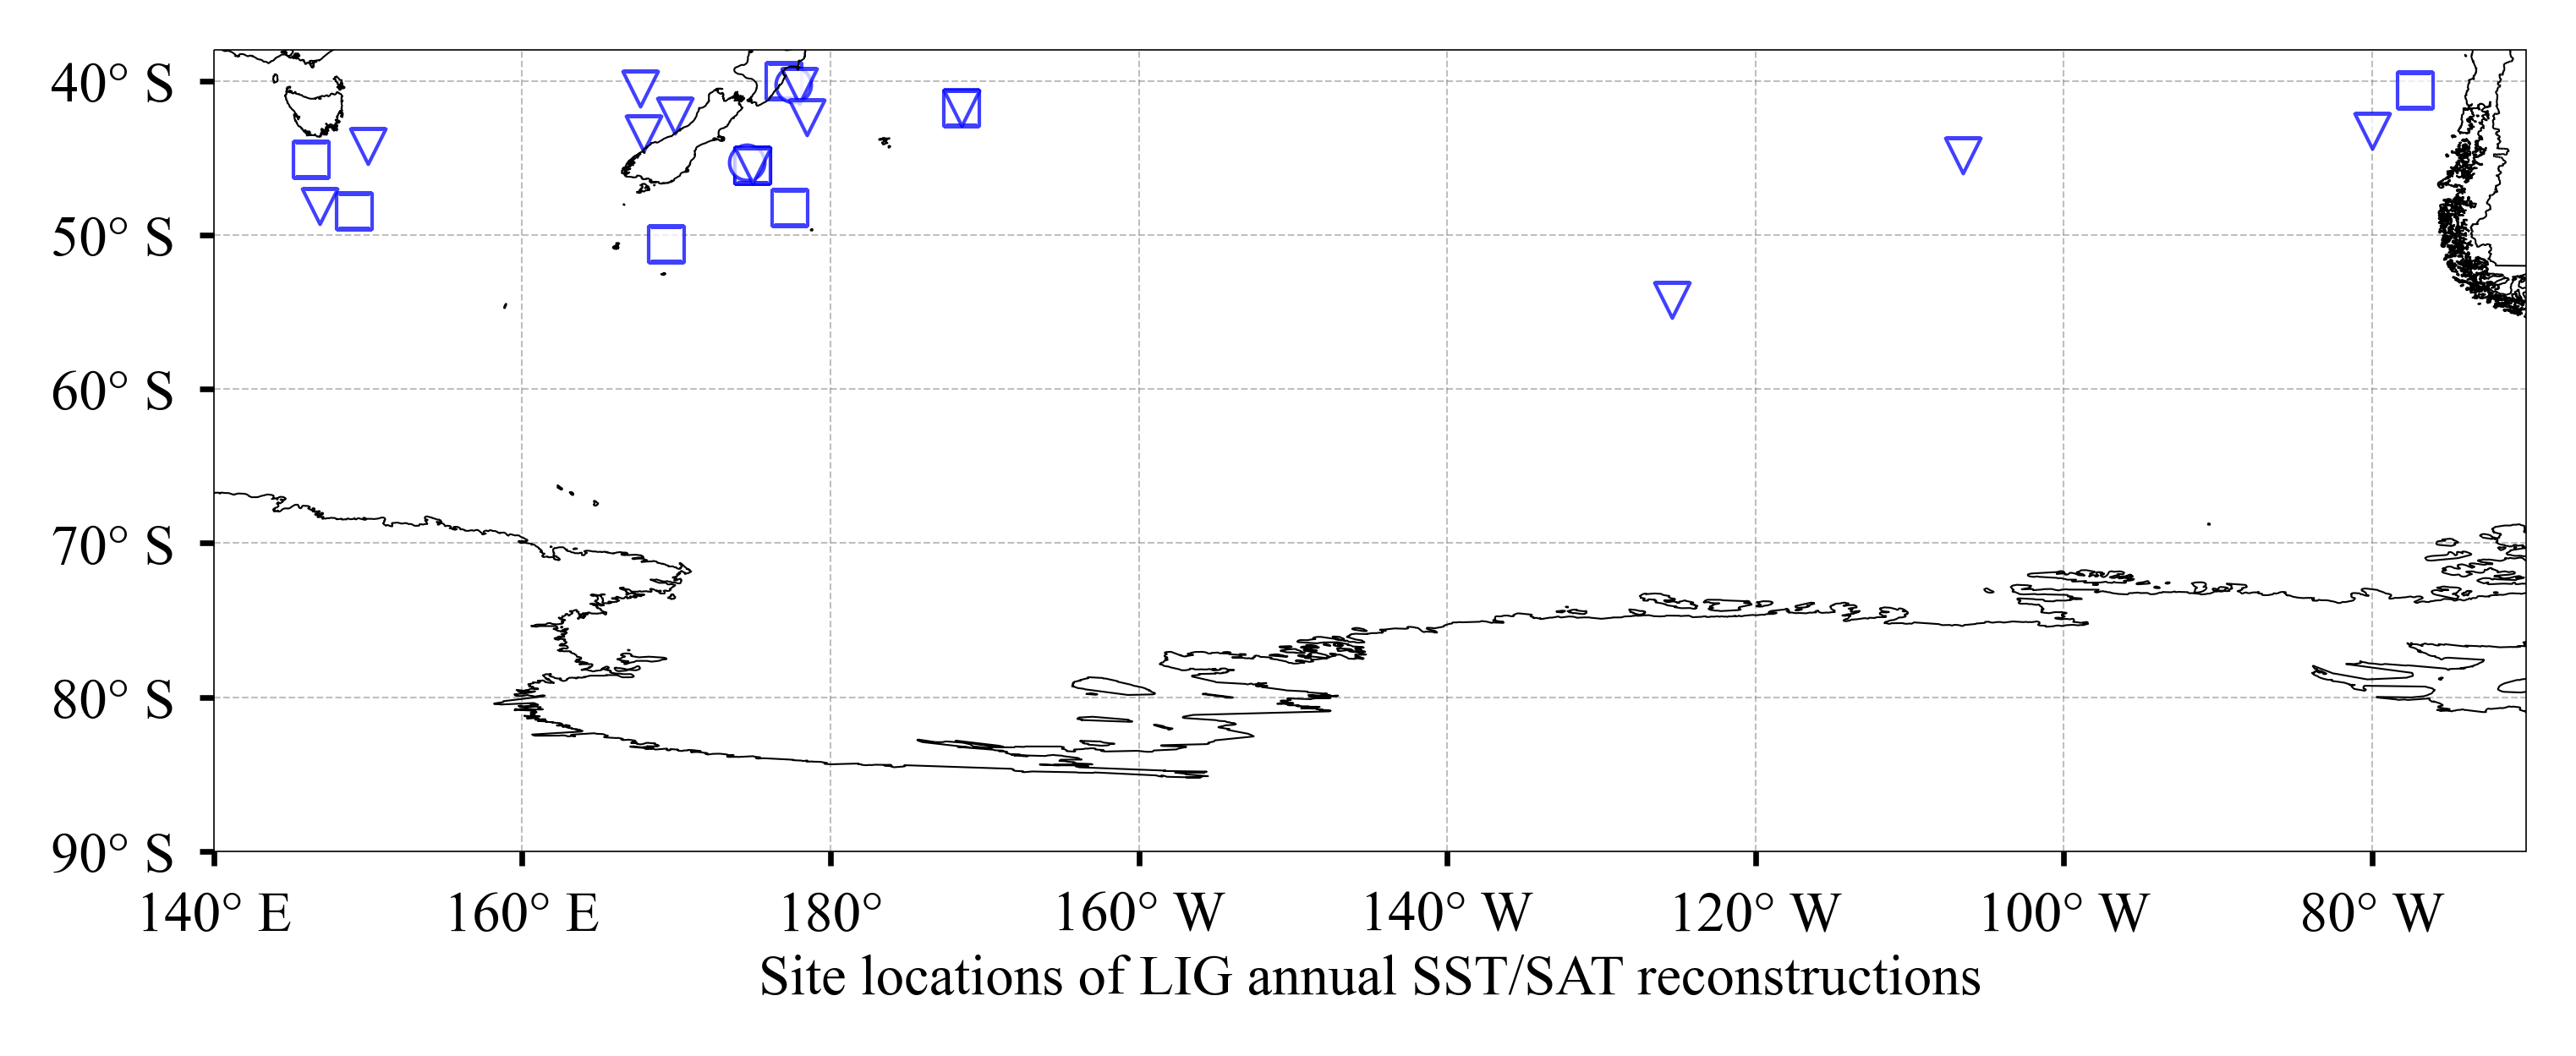

In [41]:
extent=[140, 290, -90, -38]
fig, ax = regional_plot(
    extent=extent, figsize = np.array([13, 6.4]) / 2.54,
    central_longitude = 180)

# JH
ax.scatter(
    x = lig_recs['JH']['SO_ann'].Longitude,
    y = lig_recs['JH']['SO_ann'].Latitude,
    c = 'white', s = symbol_size,
    lw=0.5, marker='s', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# EC SST
ax.scatter(
    x = lig_recs['EC']['SO_ann'].Longitude,
    y = lig_recs['EC']['SO_ann'].Latitude,
    c = 'white', s = symbol_size,
    lw=0.5, marker='o', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# EC SAT
ax.scatter(
    x = lig_recs['EC']['AIS_am'].Longitude,
    y = lig_recs['EC']['AIS_am'].Latitude,
    c = 'white', s = symbol_size,
    lw=0.5, marker='o', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# DC
plt_scatter = ax.scatter(
    x = lig_recs['DC']['annual_128'].Longitude,
    y = lig_recs['DC']['annual_128'].Latitude,
    c = 'white', s = symbol_size,
    lw=0.5, marker='v', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

plt.text(
    0.5, -0.16, 'Site locations of LIG annual SST/SAT reconstructions',
    horizontalalignment='center', verticalalignment='center',
    transform=ax.transAxes)

### Summer SST

Text(0.5, -0.16, 'Site locations of LIG summer SST reconstructions')

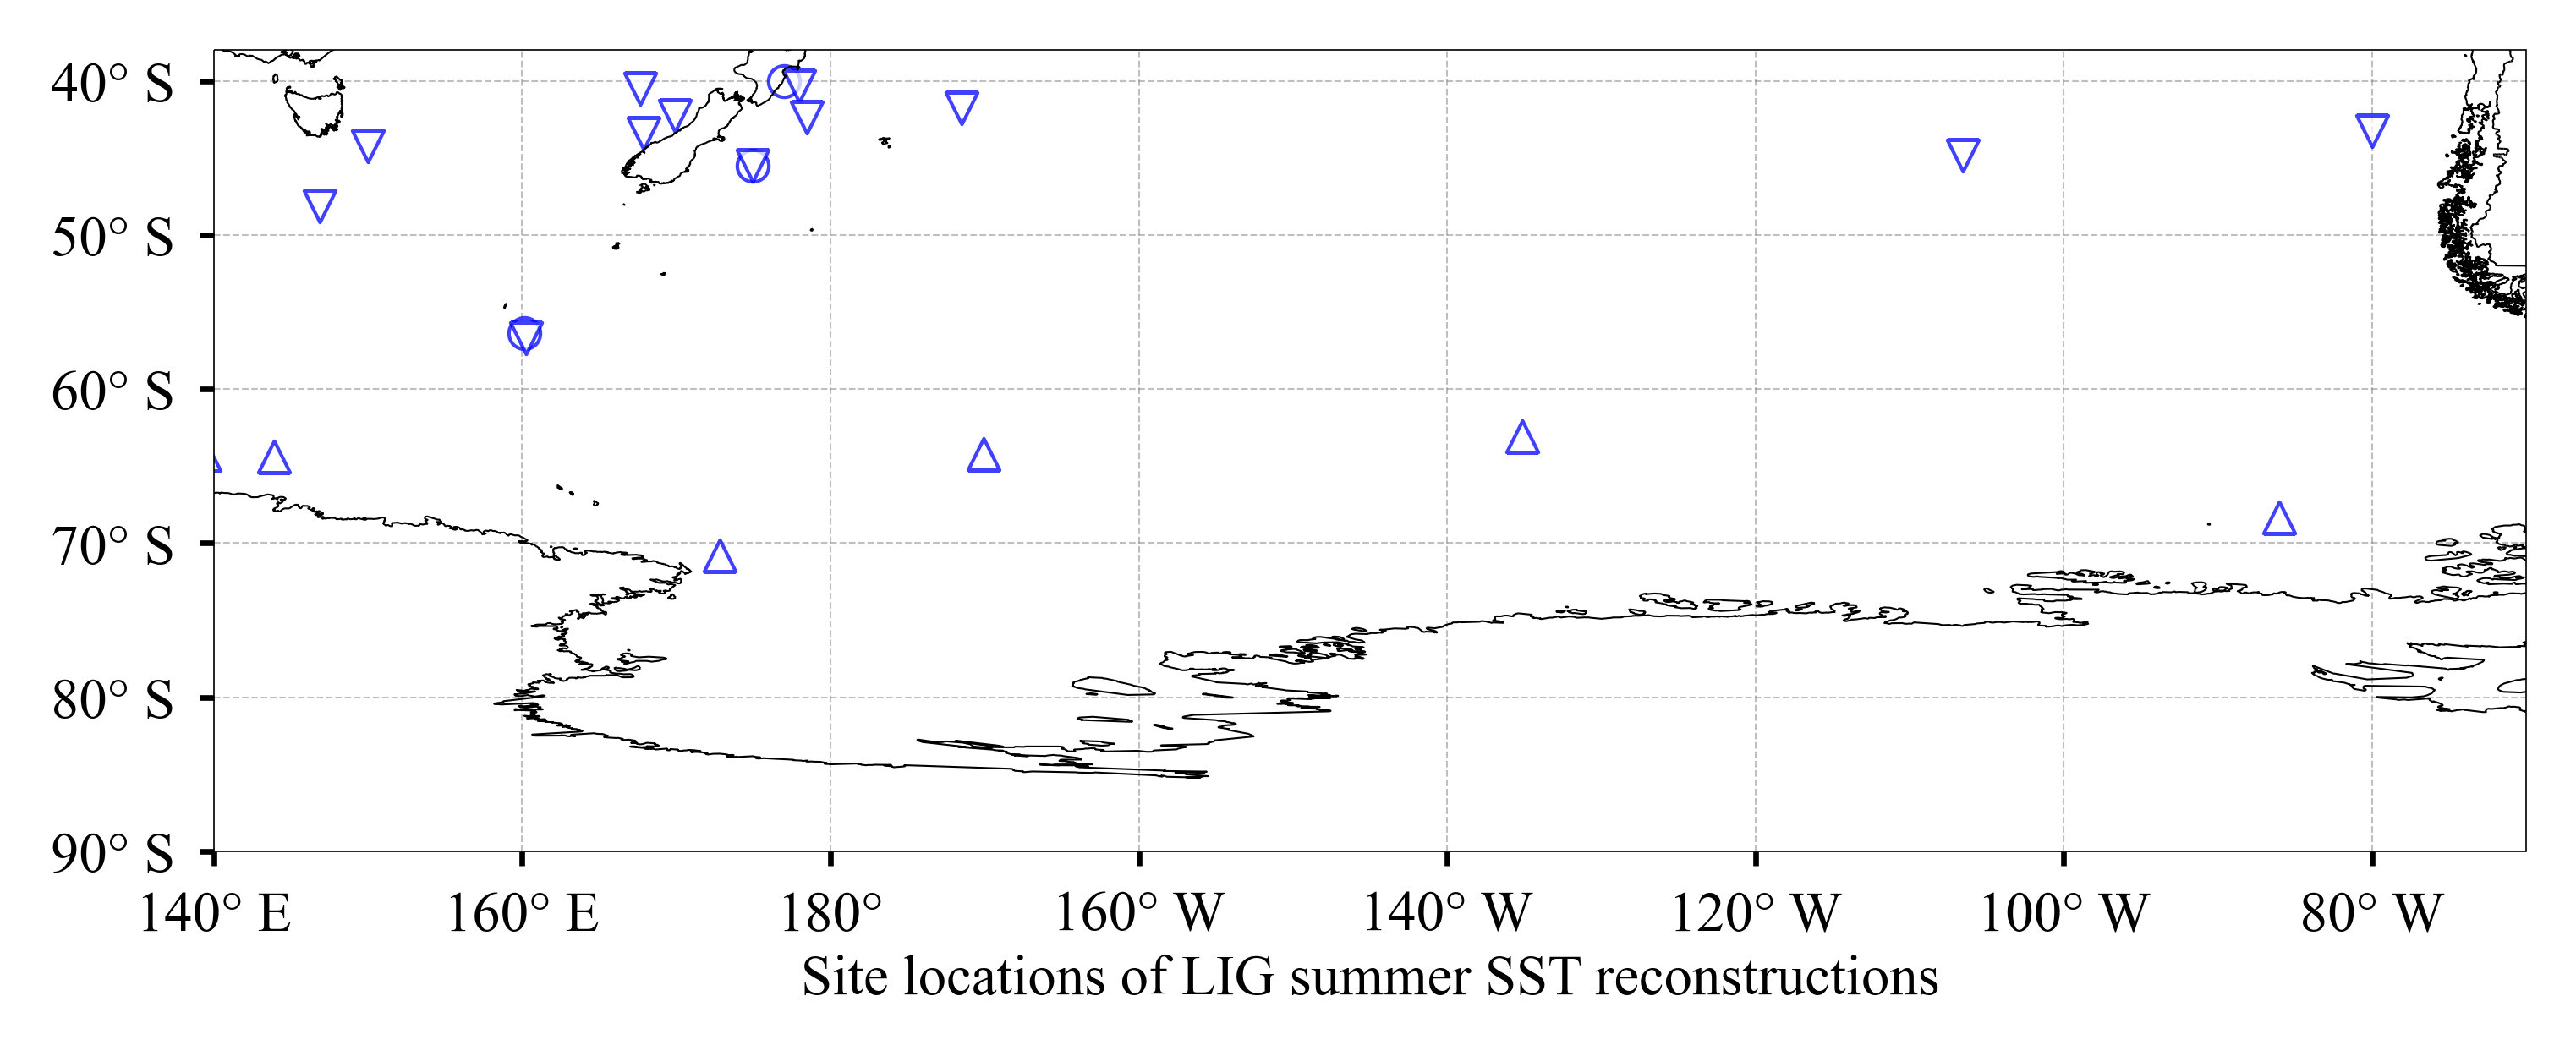

In [42]:
extent=[140, 290, -90, -38]
fig, ax = regional_plot(
    extent=extent, figsize = np.array([13, 6.4]) / 2.54,
    central_longitude = 180)

# JH
ax.scatter(
    x = lig_recs['JH']['SO_jfm'].Longitude,
    y = lig_recs['JH']['SO_jfm'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='s', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# EC
ax.scatter(
    x = lig_recs['EC']['SO_jfm'].Longitude,
    y = lig_recs['EC']['SO_jfm'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='o', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# MC
ax.scatter(
    x = lig_recs['MC']['interpolated'].Longitude,
    y = lig_recs['MC']['interpolated'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='^', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)

# DC
plt_scatter = ax.scatter(
    x = lig_recs['DC']['JFM_128'].Longitude,
    y = lig_recs['DC']['JFM_128'].Latitude,
    c = 'white', s = 20,
    lw=0.5, marker='v', edgecolors = 'blue', zorder=2, alpha=0.75,
    transform=ccrs.PlateCarree(),)
plt.text(
    0.5, -0.16, 'Site locations of LIG summer SST reconstructions',
    horizontalalignment='center', verticalalignment='center',
    transform=ax.transAxes)